In [1]:
import sys
# sys.path.append(r"Y:\Users\Yingyue\Gates_Lab_Suite-master")
sys.path.append(r"/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master")
from Core_Definition import *
from Auto_Algorithm import *
from Visualization import *
import os
from SPAM import *
import numpy as np
import xlsxwriter as xlsx
from scipy import optimize
import random
import math
from math import floor
import pickle
import uuid

In [2]:
import json, pickle
import qiskit
#transpiler reducinig qiskit circuit to QASM strings
from qiskit import transpile
# Use AerSimulator
from qiskit_aer import AerSimulator
from qiskit import IBMQ, QuantumCircuit, execute
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.extensions import UnitaryGate
from qiskit.quantum_info import Pauli, Clifford, Statevector,Operator
from qiskit.visualization import array_to_latex
from scipy.stats import sem, unitary_group
from scipy.linalg import sqrtm,expm
import qiskit.quantum_info as qi
from qiskit.quantum_info import Pauli
import pylatexenc

In [3]:
def state_init_bell_pairs(qc,n):
    for i in range (n):
        qc.Add_Gate(Quantum_Gate("HAD",i))
    for i in range (n):
        qc.Add_Gate(Quantum_Gate("CNOT",i,int(i+n)))

        
#should we set_mapping in this function? need to think about if it takes mapping into account   
def add_pauli_twirl(qc,n):
    pauliLayer = [random.choice(['I','X','Y','Z']) for j in range(n)]
    q_index=0
    for pauli in pauliLayer :
        if (pauli=="I"):
            qc.Add_Gate(Quantum_Gate("SKAX",2*n,angle=1))
        elif (pauli=="X"):
            qc.Add_Gate(Quantum_Gate("SKAX",q_index,angle=1))
        elif (pauli=="Y"):
            qc.Add_Gate(Quantum_Gate("SKAY",q_index,angle=1))
        elif (pauli=="Z"):
            qc.Add_Gate(Quantum_Gate("AZ",q_index,angle=1))
        q_index+=1
    return pauliLayer

def add_pauli_twirl_wSE(qc,n):
    pauliLayer = [random.choice(['I','X','Y','Z']) for j in range(n)]
    q_index=0
    for pauli in pauliLayer :
        if (pauli=="I"):
            qc.Add_Gate(Quantum_Gate("SKAX",2*n,angle=1))
        elif (pauli=="X"):
            qc.Add_Gate(Quantum_Gate("SKAX",q_index,angle=1))
        elif (pauli=="Y"):
            qc.Add_Gate(Quantum_Gate("SKAY",q_index,angle=1))
        elif (pauli=="Z"):
            qc.Add_Gate(Quantum_Gate("AZ",q_index,angle=1))
        
        if (q_index==(int(n/2)-1)):
            for i in range (n):
                qc.Add_Gate(Quantum_Gate("SKAX",n+i,angle=1))
        q_index+=1
    return pauliLayer
    
def add_clifford_layer(qc,n,clifford):
    if (clifford=="CNOT"):
        for i in range (floor(n/2)):
            qc.Add_Gate(Quantum_Gate("CNOT",2*i,2*i+1))
            
def bell_measurement(qc,n):
    for i in range (n-1,-1,-1):
        qc.Add_Gate(Quantum_Gate("SKAX",int(i+n),angle=1))
        qc.Add_Gate(Quantum_Gate("CNOT",i,int(i+n)))
    for i in range (n-1,-1,-1):
        qc.Add_Gate(Quantum_Gate("HAD",i))

def map_statepop_2_ibm_mapping(counts,n):
    counts_ibm_mapping=[0 for i in range (2**(2*n))]
    idx_ibm_mapping=[]
    counts_ibm_mapping_dic={}
    if len(str((2*n)))<2:
        f="00"+str(2*n)+"b"
    elif len(str((2*n)))<3:
        f="0"+str(2*n)+"b"
    else:
        raise ValueError("n is too big")
    for gates_idx in range (2**(2*n)):
        gates_idx_str=format(gates_idx,f)
        ibm_idx=0
        for i in range (2*n):
            ibm_idx+=2**(i)*int(gates_idx_str[i])
        ibm_idx_str=format(ibm_idx,f)
#         idx_ibm_mapping.append(ibm_idx_str)
        counts_ibm_mapping[ibm_idx]=counts[gates_idx]
        counts_ibm_mapping_dic[ibm_idx_str]=counts[gates_idx]
    return counts_ibm_mapping, counts_ibm_mapping_dic
        
        
#for qiskit
def prepare_bell_state_1q(circuit,index1,index2):
	circuit.h([index1])
	circuit.cx([index1],[index2])
        
def bell_measurement_1q(circuit,index1,index2): 
	# info qubit at index1
	circuit.cx([index1],[index2])
	circuit.h([index1])

def pauli_gate_1q(circuit,index,pauli=None): #For stabilizer simulator to work, cannot use Pauli class
	if pauli == 'I':
		circuit.id([index])
	elif pauli == 'Z':
		circuit.z([index])
	elif pauli == 'X':
		circuit.x([index])
	elif pauli == 'Y':
		circuit.y([index])
	else:
		assert 1==0

    
    
    

In [4]:
## Additional functions

def int_to_pauli(i,n):
    p = np.base_repr(i,base=4)
    p = '0'*(n-len(p)) + p
    p = p.replace('0','I').replace('1', 'X').replace('2', 'Y').replace('3', 'Z')
    return p

def commute(p,q):
    c = 1
    n = len(p)
    for i in range(n):
        if p[i] != 'I' and q[i] != 'I':
            if p[i] != q[i]:
                c *= -1
    return c

def fidelity_to_error(pauli_fidelity,n):
    N = 4**n
    pauli_error = {}
    for i in range(N):
        p = int_to_pauli(i,n)
        pauli_error[p] = 0
        for j in range(N):
            q = int_to_pauli(j,n)
            pauli_error[p] += pauli_fidelity[q] * commute(p,q) / N
    return pauli_error
    

In [5]:
Set_Mapping([2,3,5,4,1])
nqubit=2
C=10
results_d2=np.zeros((C,2**(2*nqubit)))
results_d4=np.zeros((C,2**(2*nqubit)))
results_d8=np.zeros((C,2**(2*nqubit)))

file=open(r"/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/circuits/23541 EAB XX C=10 0424 /d=8.txt", 'r')
Lines= file.readlines()
c_d8=[]
count = 0
for line in Lines:
    c_d8.append(line)
    count += 1
print (count)
count=0

file=open(r"/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/circuits/23541 EAB XX C=10 0424 /d=4.txt", 'r')
Lines= file.readlines()
c_d4=[]
count = 0
for line in Lines:
    c_d4.append(line)
    count += 1
print (count)
count=0

file=open(r"/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/circuits/23541 EAB XX C=10 0424 /d=2.txt", 'r')
Lines= file.readlines()
c_d2=[]
count = 0
for line in Lines:
    c_d2.append(line)
    count += 1
print (count)
count=0


10
10
10


In [6]:
filenames_d2=[]
filenames_d4=[]
filenames_d8=[]
filenames=[]

paf_data_d2="/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0424/2023-04-24 eab__d=2 q2error idle channel off/"
L1=[]
filenames=[]
line_Idx="000"
line_num=""
p=0 #position indicator

#------------------------------------------read in raw data-------------------------------
for f in os.listdir(paf_data_d2):
    if (f.find("Line")!=-1):
        n=f.find("_")
        line_Idx=f[n+6:n+9]
        for i in range(3):
            if line_Idx[i]=="0":
                p+=1
            else:
                line_num=line_Idx[p:3]
                p=0
                break
        L1.append(int(line_num))
        filenames.append(f)
    else:
        print (f) #print out non datafiles just for debugging 
        continue
for Idx in range (len(filenames)):
    for i in range (len(filenames)):
        if L1[i]==Idx+1:
            filenames_d2.append(filenames[i])
            break
print (filenames_d2)

paf_data_d4="/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0424/2023-04-24 eab__d=4/"
L1=[]
filenames=[]
line_Idx="000"
line_num=""
p=0 #position indicator

#------------------------------------------read in raw data-------------------------------
for f in os.listdir(paf_data_d4):
    if (f.find("Line")!=-1):
        n=f.find("_")
        line_Idx=f[n+6:n+9]
        for i in range(3):
            if line_Idx[i]=="0":
                p+=1
            else:
                line_num=line_Idx[p:3]
                p=0
                break
        L1.append(int(line_num))
        filenames.append(f)
    else:
        print (f) #print out non datafiles just for debugging 
        continue
for Idx in range (len(filenames)):
    for i in range (len(filenames)):
        if L1[i]==Idx+1:
            filenames_d4.append(filenames[i])
            break
print (filenames_d4)

paf_data_d8="/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0424/2023-04-24 eab__d=8/"
L1=[]
filenames=[]
line_Idx="000"
line_num=""
p=0 #position indicator

#------------------------------------------read in raw data-------------------------------
for f in os.listdir(paf_data_d8 ):
    if (f.find("Line")!=-1):
        n=f.find("_")
        line_Idx=f[n+6:n+9]
        for i in range(3):
            if line_Idx[i]=="0":
                p+=1
            else:
                line_num=line_Idx[p:3]
                p=0
                break
        L1.append(int(line_num))
        filenames.append(f)
    else:
        print (f) #print out non datafiles just for debugging 
        continue
for Idx in range (len(filenames)):
    for i in range (len(filenames)):
        if L1[i]==Idx+1:
            filenames_d8.append(filenames[i])
            break
print (filenames_d8)

archive
['2023-04-24-135453_Line_001.txt', '2023-04-24-135531_Line_002.txt', '2023-04-24-135609_Line_003.txt', '2023-04-24-140215_Line_004.txt', '2023-04-24-143725_Line_005.txt', '2023-04-24-143803_Line_006.txt', '2023-04-24-143840_Line_007.txt', '2023-04-24-164022_Line_008.txt', '2023-04-24-164100_Line_009.txt', '2023-04-24-164140_Line_010.txt']
['2023-04-24-164350_Line_001.txt', '2023-04-24-164436_Line_002.txt', '2023-04-24-164521_Line_003.txt', '2023-04-24-164609_Line_004.txt', '2023-04-24-170742_Line_005.txt', '2023-04-24-170828_Line_006.txt', '2023-04-24-170913_Line_007.txt', '2023-04-24-171107_Line_008.txt', '2023-04-24-171152_Line_009.txt', '2023-04-24-171238_Line_010 ion dropped after this line.txt']
['2023-04-24-174119_Line_001.txt', '2023-04-24-174216_Line_002.txt', '2023-04-24-174316_Line_003.txt', '2023-04-24-174525_Line_004.txt', '2023-04-24-174627_Line_005.txt', '2023-04-24-174727_Line_006.txt', '2023-04-24-174937_Line_007.txt', '2023-04-24-175039_Line_008.txt', '2023-04-

In [7]:
a=Quantum_State(5)
a_s=Quantum_State(5)
b_c=Quantum_Circuit(5,"qc")

spam1=SPAM_Operator(5)
spam1.Import("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0424/SPAM1/SPAM1.csv")

spam2=SPAM_Operator(5)
spam2.Import("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0424/SPAM1/SPAM1.csv")


2023-04-24-135453_Line_001.txt
counts: [8, 52, 5, 6, 10, 270, 16, 23, 34, 283, 46, 15, 70, 2929, 131, 102]
counts_ibm_mapping_dic: {'0000': 8, '1000': 52, '0100': 5, '1100': 6, '0010': 10, '1010': 270, '0110': 16, '1110': 23, '0001': 34, '1001': 283, '0101': 46, '1101': 15, '0011': 70, '1011': 2929, '0111': 131, '1111': 102}
HAD2:HAD3:CNOT25:CNOT34:SKAY2+1.0000:AZ3+1.0000:XA230.2500+:SKAY2+1.0000:SKAX5+1.0000:SKAX4+1.0000:AZ3+1.0000:XA230.2500+:SKAY2+1.0000:AZ3+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2



/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/SPAM.py:32: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  temp.population=np.linalg.lstsq(self.matrix,state.population)[0]


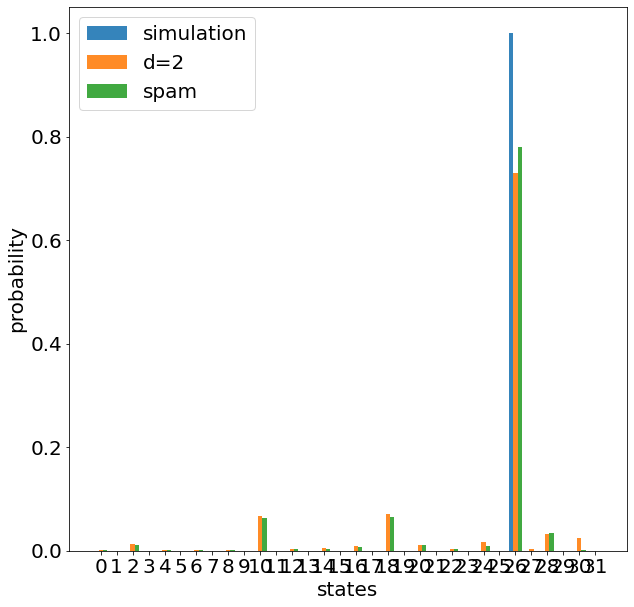

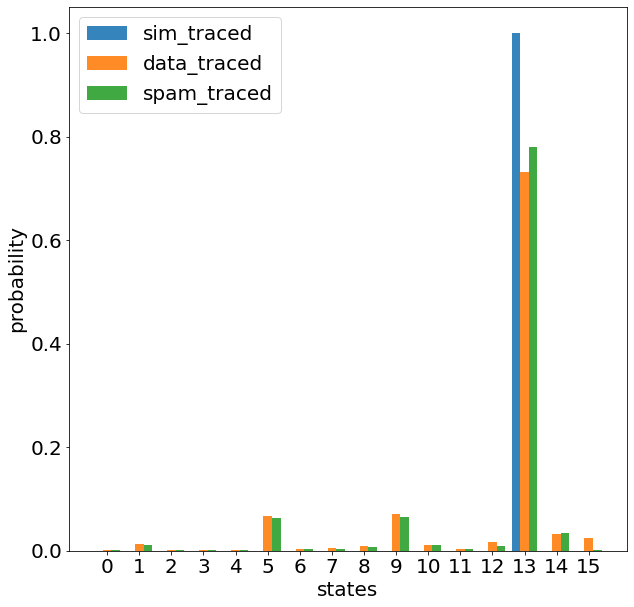

2023-04-24-135531_Line_002.txt
counts: [11, 266, 18, 32, 19, 23, 12, 11, 93, 3093, 19, 109, 62, 211, 11, 10]
counts_ibm_mapping_dic: {'0000': 11, '1000': 266, '0100': 18, '1100': 32, '0010': 19, '1010': 23, '0110': 12, '1110': 11, '0001': 93, '1001': 3093, '0101': 19, '1101': 109, '0011': 62, '1011': 211, '0111': 11, '1111': 10}
HAD2:HAD3:CNOT25:CNOT34:SKAY2+1.0000:SKAX3+1.0000:XA230.2500+:SKAY2+1.0000:SKAX5+1.0000:SKAX4+1.0000:SKAX3+1.0000:XA230.2500+:AZ2+1.0000:SKAX3+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2



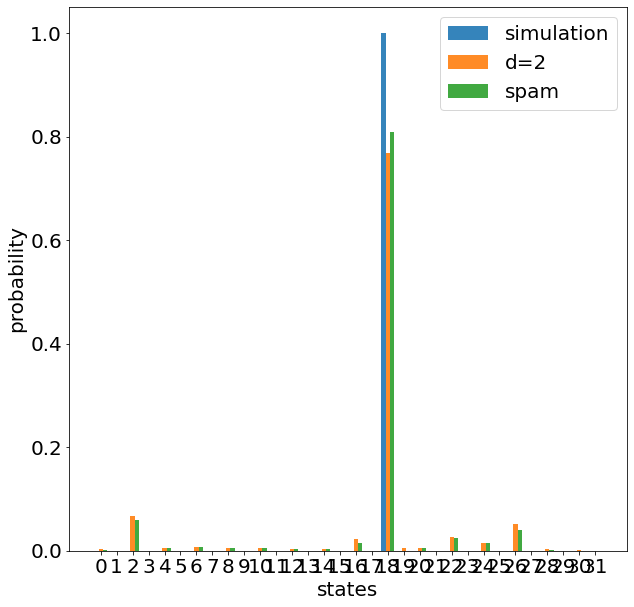

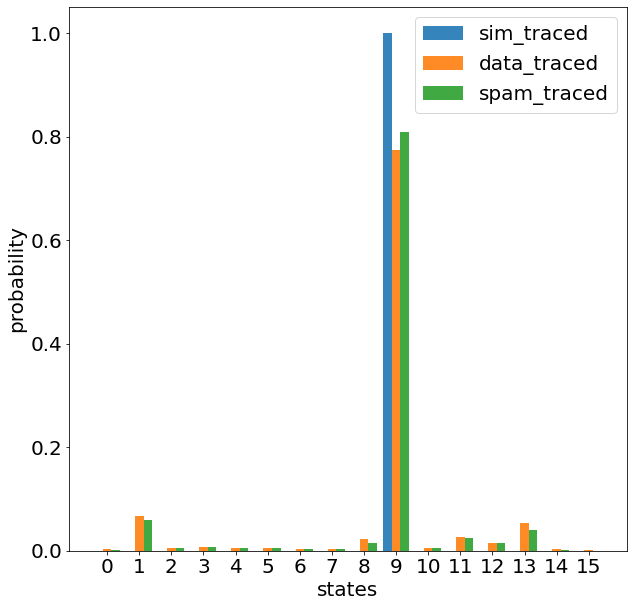

2023-04-24-135609_Line_003.txt
counts: [243, 11, 33, 96, 47, 14, 5, 15, 2867, 45, 58, 110, 302, 71, 5, 78]
counts_ibm_mapping_dic: {'0000': 243, '1000': 11, '0100': 33, '1100': 96, '0010': 47, '1010': 14, '0110': 5, '1110': 15, '0001': 2867, '1001': 45, '0101': 58, '1101': 110, '0011': 302, '1011': 71, '0111': 5, '1111': 78}
HAD2:HAD3:CNOT25:CNOT34:SKAX2+1.0000:SKAX1+1.0000:XA230.2500+:SKAX1+1.0000:SKAX5+1.0000:SKAX4+1.0000:SKAX1+1.0000:XA230.2500+:AZ2+1.0000:SKAX3+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2



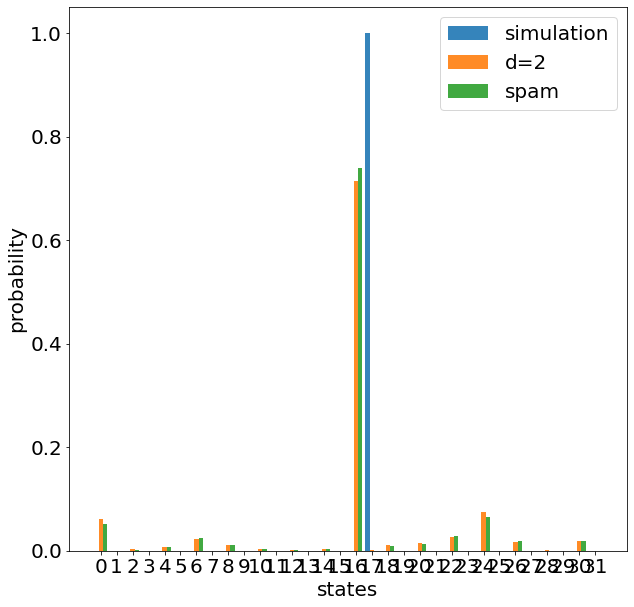

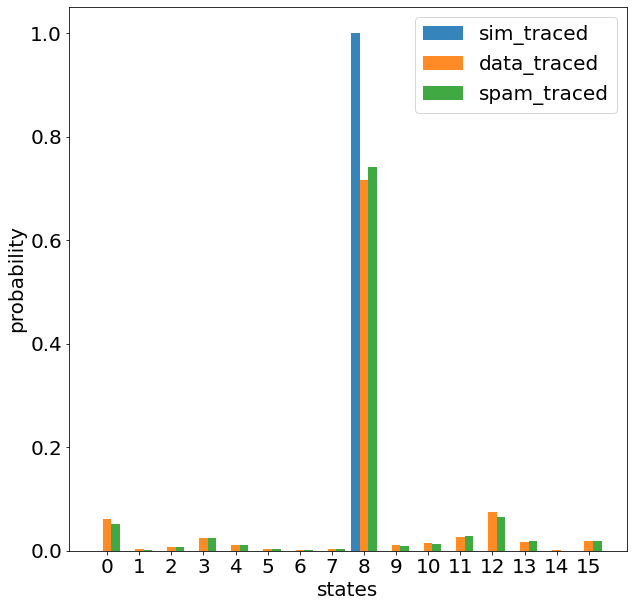

2023-04-24-140215_Line_004.txt
counts: [39, 118, 16, 8, 71, 2924, 8, 116, 14, 34, 7, 7, 17, 564, 15, 42]
counts_ibm_mapping_dic: {'0000': 39, '1000': 118, '0100': 16, '1100': 8, '0010': 71, '1010': 2924, '0110': 8, '1110': 116, '0001': 14, '1001': 34, '0101': 7, '1101': 7, '0011': 17, '1011': 564, '0111': 15, '1111': 42}
HAD2:HAD3:CNOT25:CNOT34:SKAX1+1.0000:SKAX3+1.0000:XA230.2500+:SKAX2+1.0000:SKAX5+1.0000:SKAX4+1.0000:SKAY3+1.0000:XA230.2500+:SKAX2+1.0000:SKAX3+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2



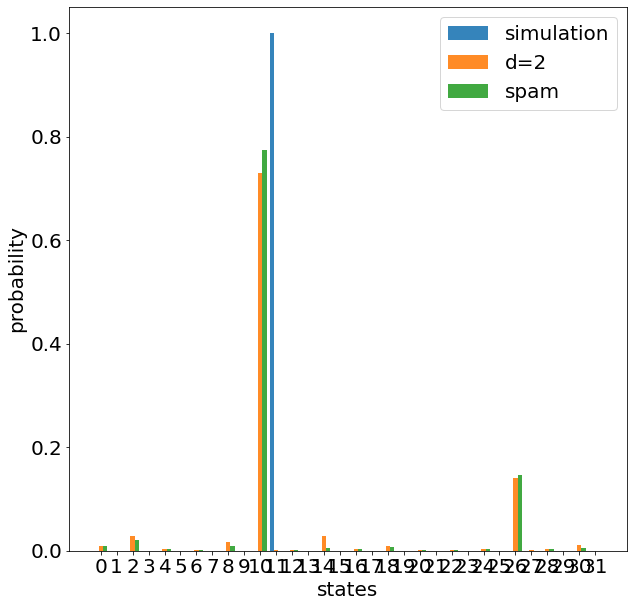

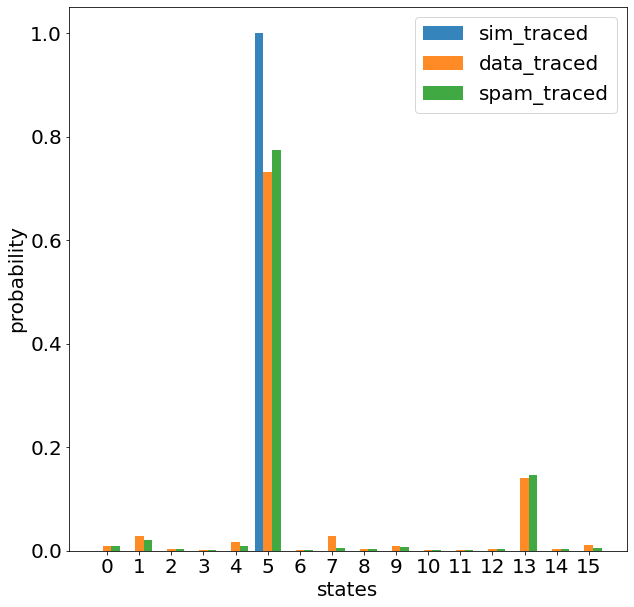

2023-04-24-143725_Line_005.txt
counts: [79, 116, 2688, 37, 5, 35, 125, 57, 20, 22, 690, 25, 2, 4, 79, 16]
counts_ibm_mapping_dic: {'0000': 79, '1000': 116, '0100': 2688, '1100': 37, '0010': 5, '1010': 35, '0110': 125, '1110': 57, '0001': 20, '1001': 22, '0101': 690, '1101': 25, '0011': 2, '1011': 4, '0111': 79, '1111': 16}
HAD2:HAD3:CNOT25:CNOT34:SKAX2+1.0000:SKAX1+1.0000:XA230.2500+:SKAX2+1.0000:SKAX5+1.0000:SKAX4+1.0000:SKAX3+1.0000:XA230.2500+:SKAX1+1.0000:SKAX1+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2



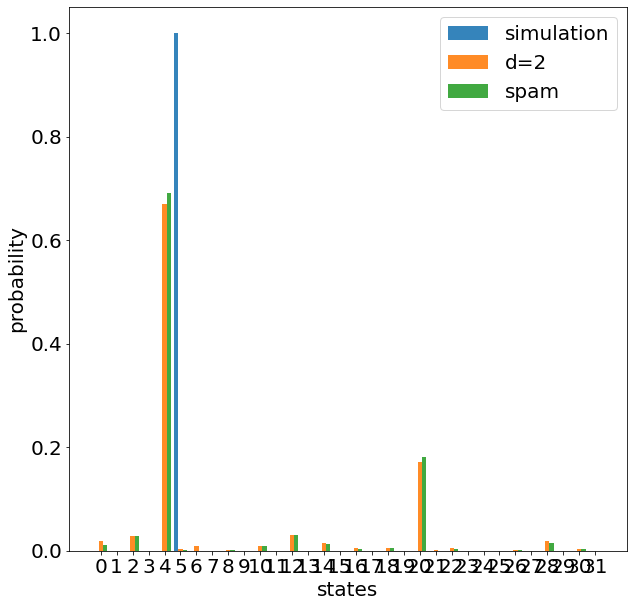

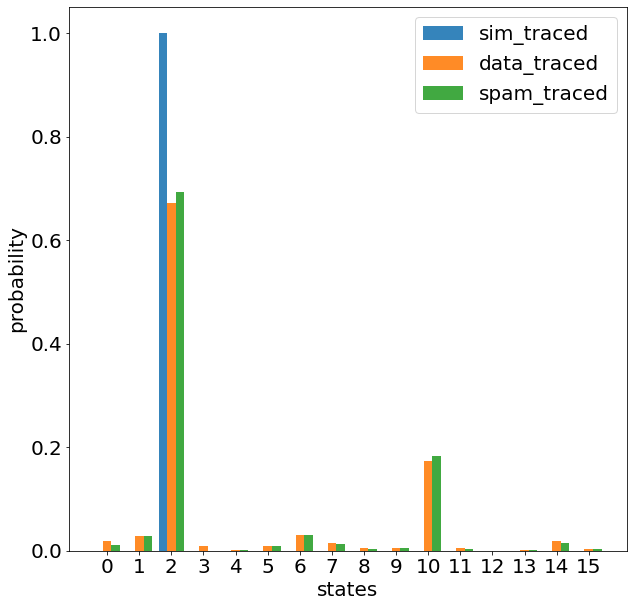

2023-04-24-143803_Line_006.txt
counts: [4, 15, 128, 100, 57, 10, 2598, 127, 0, 3, 78, 33, 31, 14, 754, 48]
counts_ibm_mapping_dic: {'0000': 4, '1000': 15, '0100': 128, '1100': 100, '0010': 57, '1010': 10, '0110': 2598, '1110': 127, '0001': 0, '1001': 3, '0101': 78, '1101': 33, '0011': 31, '1011': 14, '0111': 754, '1111': 48}
HAD2:HAD3:CNOT25:CNOT34:AZ2+1.0000:AZ3+1.0000:XA230.2500+:SKAX2+1.0000:SKAX5+1.0000:SKAX4+1.0000:SKAY3+1.0000:XA230.2500+:AZ2+1.0000:SKAY3+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2



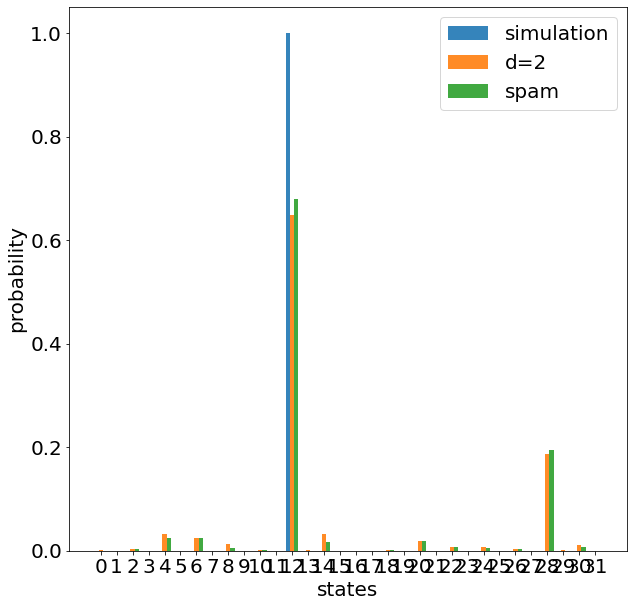

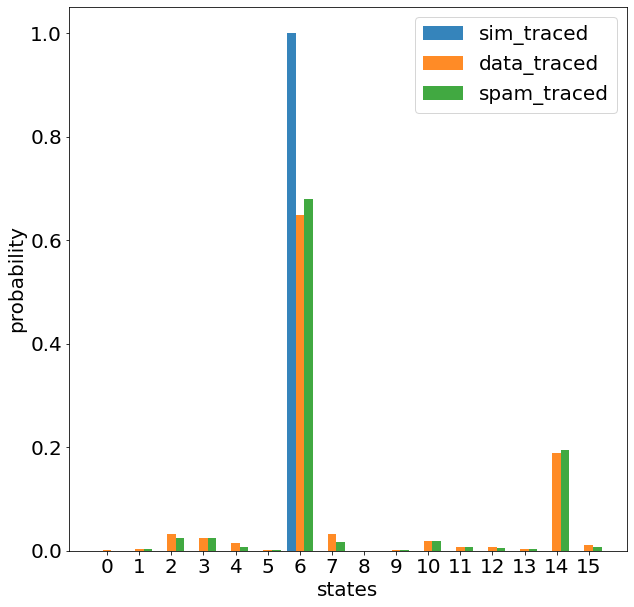

2023-04-24-143840_Line_007.txt
counts: [55, 179, 45, 7, 77, 3077, 15, 109, 17, 26, 5, 7, 14, 294, 47, 26]
counts_ibm_mapping_dic: {'0000': 55, '1000': 179, '0100': 45, '1100': 7, '0010': 77, '1010': 3077, '0110': 15, '1110': 109, '0001': 17, '1001': 26, '0101': 5, '1101': 7, '0011': 14, '1011': 294, '0111': 47, '1111': 26}
HAD2:HAD3:CNOT25:CNOT34:AZ2+1.0000:SKAX3+1.0000:XA230.2500+:AZ2+1.0000:SKAX5+1.0000:SKAX4+1.0000:SKAX1+1.0000:XA230.2500+:SKAX1+1.0000:AZ3+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2



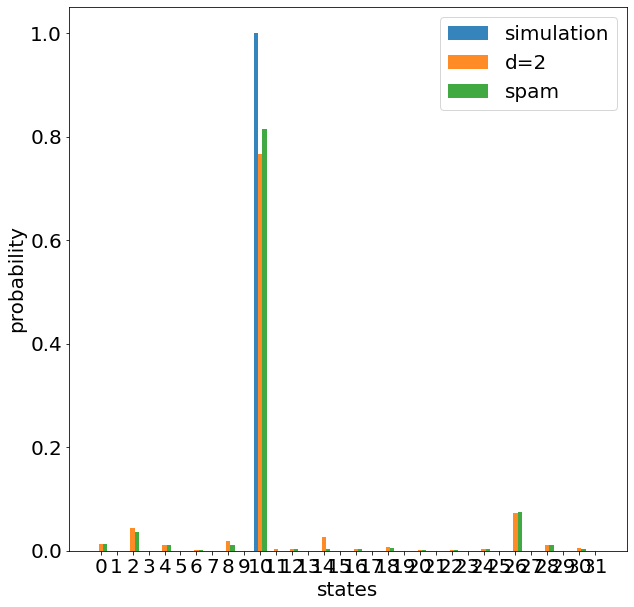

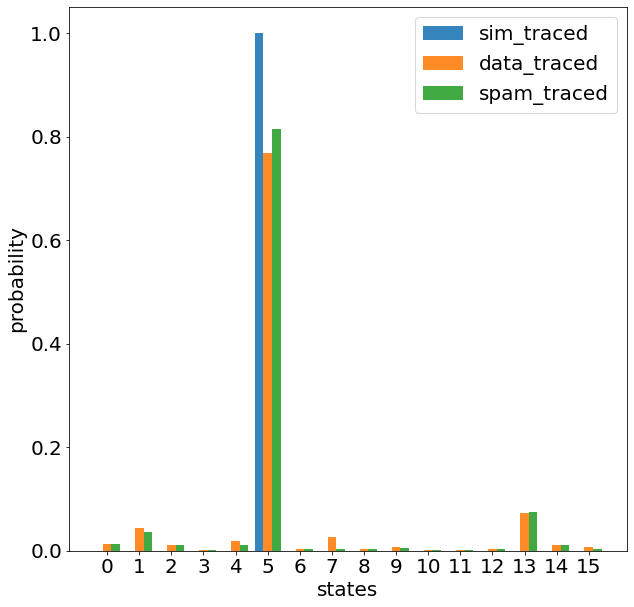

2023-04-24-164022_Line_008.txt
counts: [33, 26, 970, 15, 3, 7, 113, 26, 72, 6, 2372, 37, 10, 69, 203, 38]
counts_ibm_mapping_dic: {'0000': 33, '1000': 26, '0100': 970, '1100': 15, '0010': 3, '1010': 7, '0110': 113, '1110': 26, '0001': 72, '1001': 6, '0101': 2372, '1101': 37, '0011': 10, '1011': 69, '0111': 203, '1111': 38}
HAD2:HAD3:CNOT25:CNOT34:SKAX1+1.0000:SKAX1+1.0000:XA230.2500+:SKAY2+1.0000:SKAX5+1.0000:SKAX4+1.0000:SKAX1+1.0000:XA230.2500+:SKAX1+1.0000:SKAX1+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2



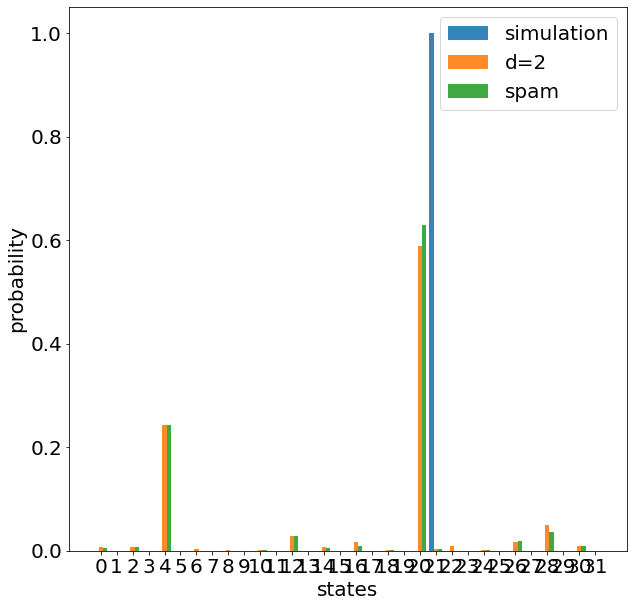

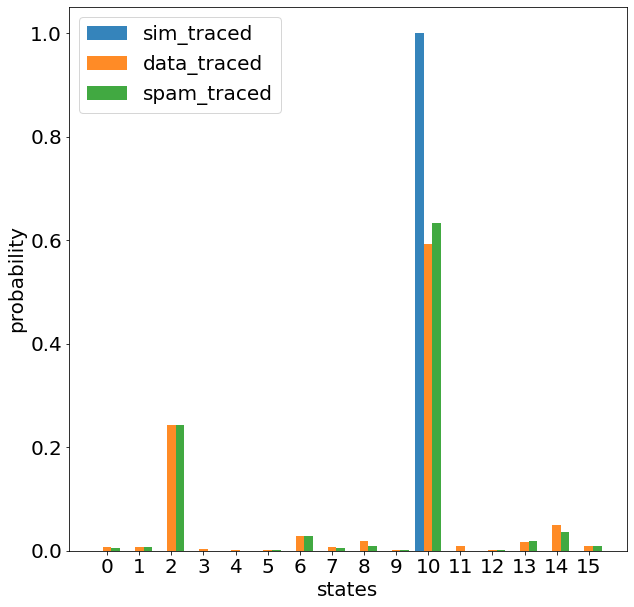

2023-04-24-164100_Line_009.txt
counts: [3134, 53, 46, 22, 283, 75, 12, 44, 203, 6, 22, 24, 45, 10, 3, 18]
counts_ibm_mapping_dic: {'0000': 3134, '1000': 53, '0100': 46, '1100': 22, '0010': 283, '1010': 75, '0110': 12, '1110': 44, '0001': 203, '1001': 6, '0101': 22, '1101': 24, '0011': 45, '1011': 10, '0111': 3, '1111': 18}
HAD2:HAD3:CNOT25:CNOT34:SKAY2+1.0000:SKAY3+1.0000:XA230.2500+:SKAX2+1.0000:SKAX5+1.0000:SKAX4+1.0000:AZ3+1.0000:XA230.2500+:AZ2+1.0000:SKAX3+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2



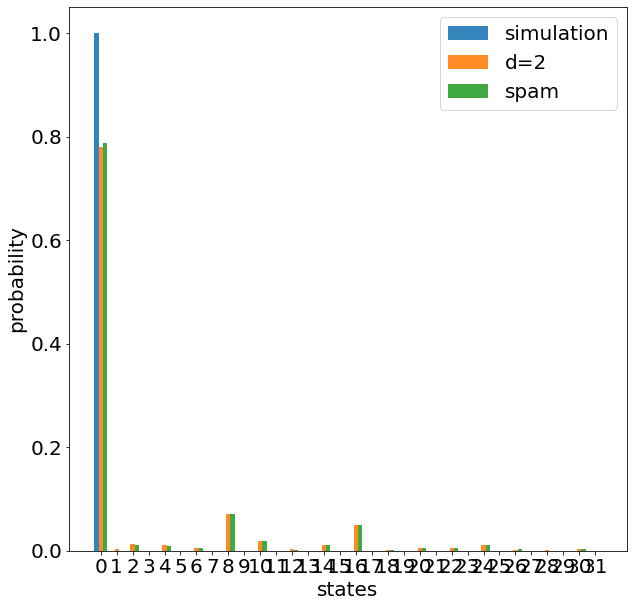

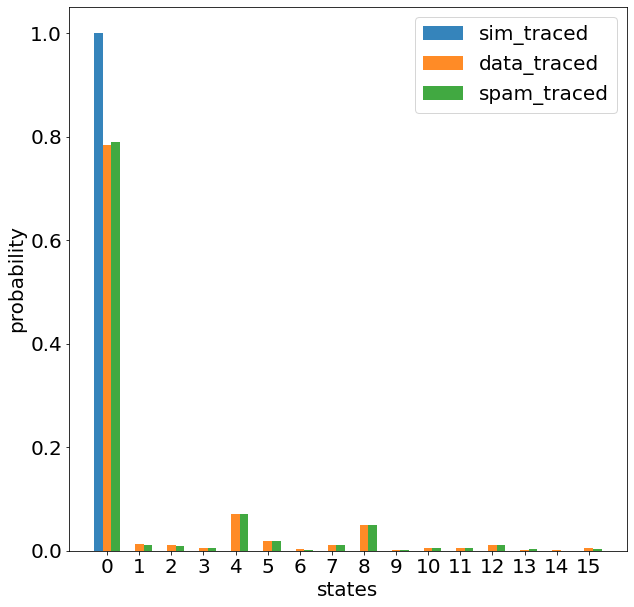

2023-04-24-164140_Line_010.txt
counts: [11, 6, 26, 154, 62, 22, 29, 729, 44, 5, 34, 180, 47, 76, 67, 2508]
counts_ibm_mapping_dic: {'0000': 11, '1000': 6, '0100': 26, '1100': 154, '0010': 62, '1010': 22, '0110': 29, '1110': 729, '0001': 44, '1001': 5, '0101': 34, '1101': 180, '0011': 47, '1011': 76, '0111': 67, '1111': 2508}
HAD2:HAD3:CNOT25:CNOT34:SKAX1+1.0000:SKAY3+1.0000:XA230.2500+:AZ2+1.0000:SKAX5+1.0000:SKAX4+1.0000:SKAX1+1.0000:XA230.2500+:SKAX2+1.0000:SKAX1+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2


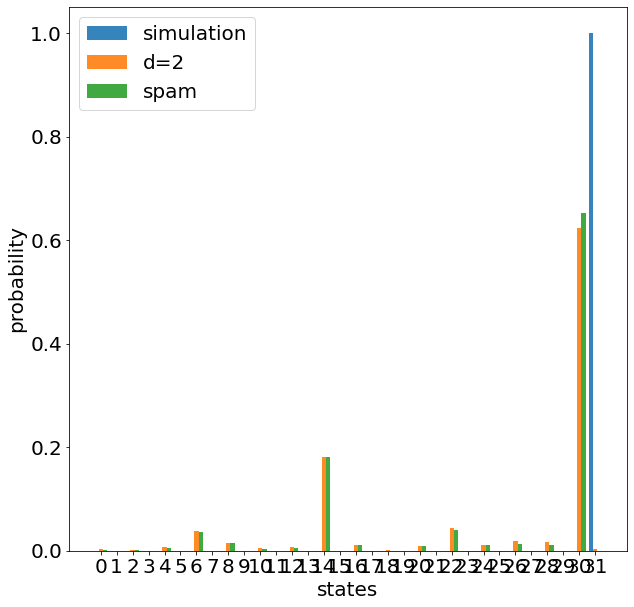

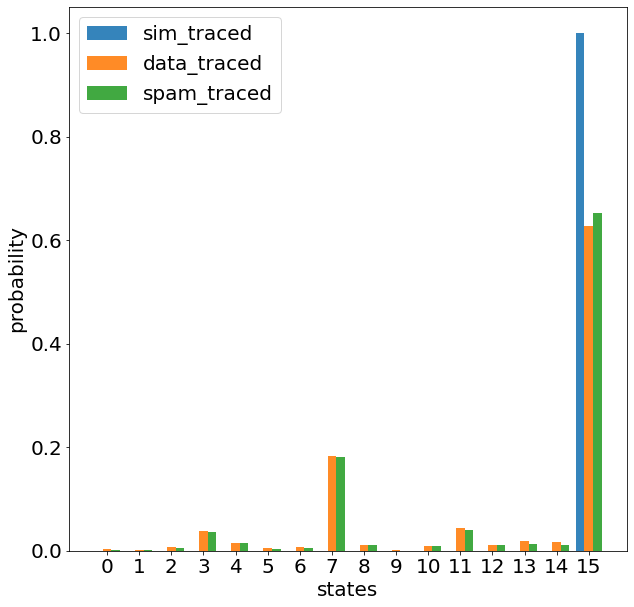

In [8]:
filenames_data=[]
counts_d2=[]
counts_d2_spam=[]
shots=4000
counts=[]
counts_spam=[]
filenames_data=filenames_d2.copy()
# print (filenames_data)
# print (len(filenames_data))
paf_data=paf_data_d2
circuit=c_d2
for i in range (len(filenames_data)):
    print (filenames_data[i])
    a.Import(paf_data+filenames_data[i],keep_file=True)
    data_traced=Trace_Out(a,[0,1,2,3])
    counts=[round(shots*x) for x in  data_traced.population]
    print ("counts:", counts)
    counts_ibm_mapping, counts_ibm_mapping_dic=map_statepop_2_ibm_mapping(counts,nqubit)
    print ("counts_ibm_mapping_dic:",counts_ibm_mapping_dic)
    counts_d2.append(counts_ibm_mapping_dic)
    
    a_s=spam1.Correct_SPAM(a)
    data_traced_spam=Trace_Out(a_s,[0,1,2,3])
    counts_spam=[round(shots*x) for x in  data_traced_spam.population]
    counts_ibm_mapping_spam, counts_ibm_mapping_dic_spam=map_statepop_2_ibm_mapping(counts_spam,nqubit)
    counts_d2_spam.append(counts_ibm_mapping_dic_spam)

    b_c.Interpret_GatesLab_Sequence(circuit[i])
    print (circuit[i])
    b=b_c.Simulate()
    sim_traced=Trace_Out(b,[0,1,2,3])
    Display_States_Population(states=[b,a,a_s],label=["simulation","d=2","spam"])
    Display_States_Population(states=[sim_traced,data_traced,data_traced_spam],label=["sim_traced","data_traced","spam_traced"])
# #         

['2023-04-24-164350_Line_001.txt', '2023-04-24-164436_Line_002.txt', '2023-04-24-164521_Line_003.txt', '2023-04-24-164609_Line_004.txt', '2023-04-24-170742_Line_005.txt', '2023-04-24-170828_Line_006.txt', '2023-04-24-170913_Line_007.txt', '2023-04-24-171107_Line_008.txt', '2023-04-24-171152_Line_009.txt', '2023-04-24-171238_Line_010 ion dropped after this line.txt']
2023-04-24-164350_Line_001.txt
HAD2:HAD3:CNOT25:CNOT34:AZ2+1.0000:SKAX3+1.0000:XA230.2500+:SKAX2+1.0000:AZ3+1.0000:XA230.2500+:SKAX1+1.0000:SKAX5+1.0000:SKAX4+1.0000:SKAX1+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:SKAX2+1.0000:SKAX1+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2



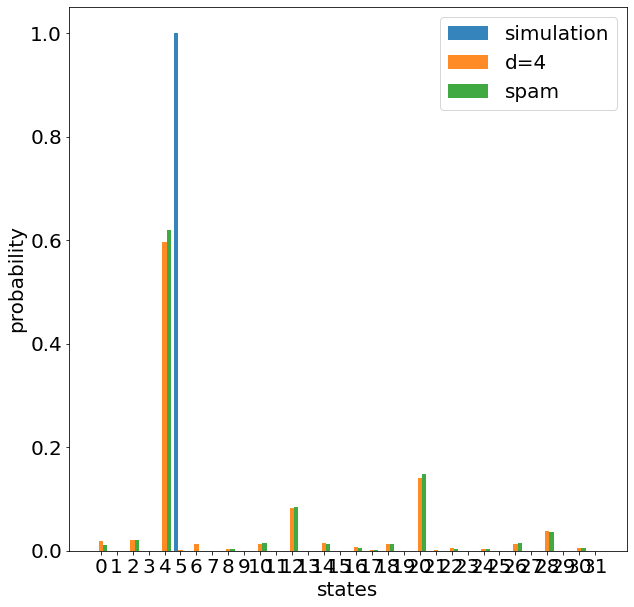

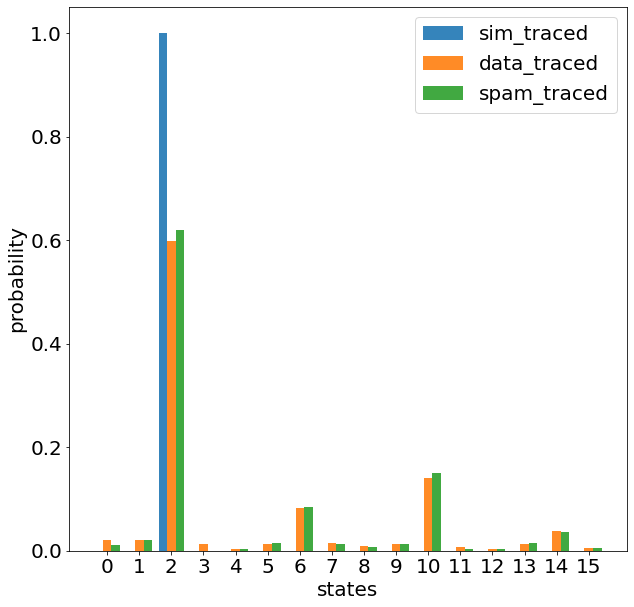

2023-04-24-164436_Line_002.txt
HAD2:HAD3:CNOT25:CNOT34:SKAX2+1.0000:SKAX3+1.0000:XA230.2500+:AZ2+1.0000:SKAY3+1.0000:XA230.2500+:SKAY2+1.0000:SKAX5+1.0000:SKAX4+1.0000:SKAX1+1.0000:XA230.2500+:SKAX2+1.0000:SKAY3+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2



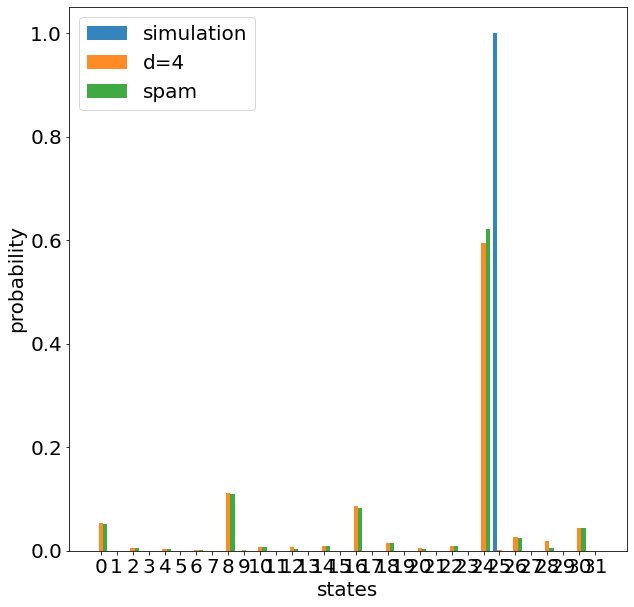

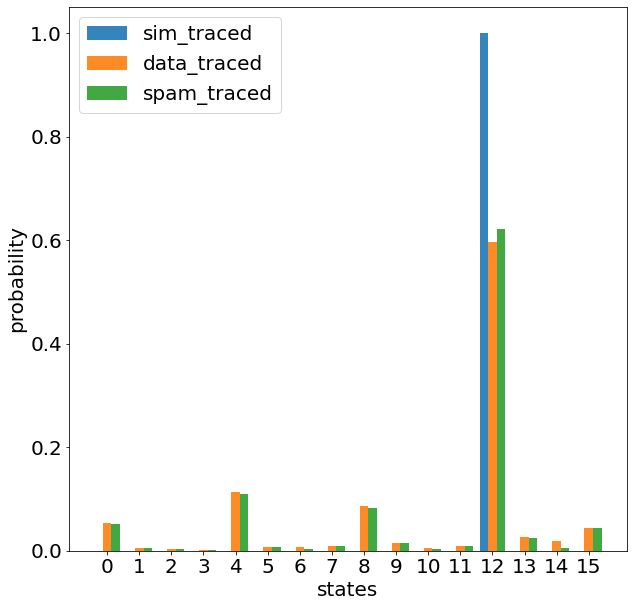

2023-04-24-164521_Line_003.txt
HAD2:HAD3:CNOT25:CNOT34:SKAX2+1.0000:SKAX3+1.0000:XA230.2500+:AZ2+1.0000:SKAX3+1.0000:XA230.2500+:SKAY2+1.0000:SKAX5+1.0000:SKAX4+1.0000:SKAY3+1.0000:XA230.2500+:SKAY2+1.0000:SKAX3+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2



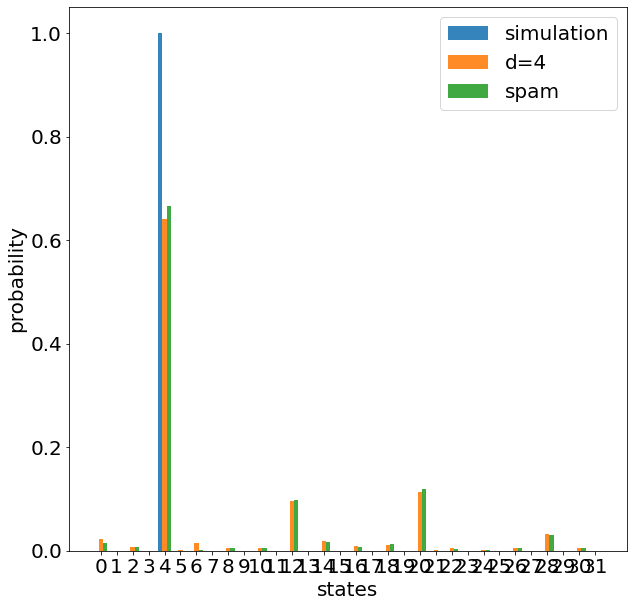

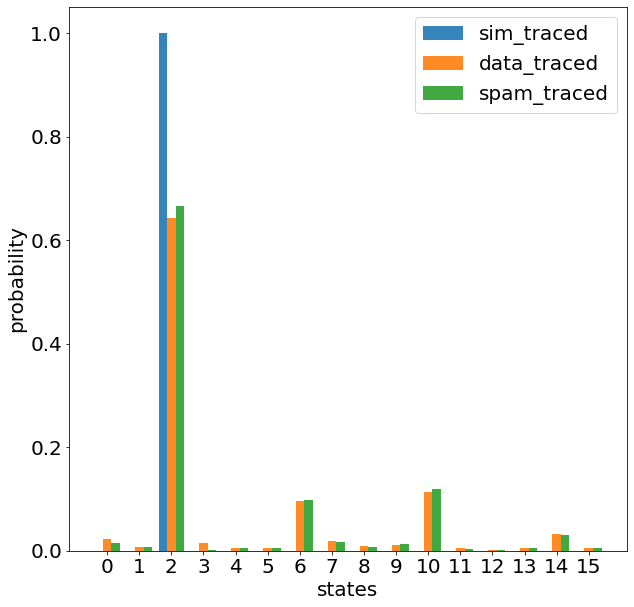

2023-04-24-164609_Line_004.txt
HAD2:HAD3:CNOT25:CNOT34:SKAX2+1.0000:SKAX3+1.0000:XA230.2500+:SKAX1+1.0000:SKAX1+1.0000:XA230.2500+:AZ2+1.0000:SKAX5+1.0000:SKAX4+1.0000:AZ3+1.0000:XA230.2500+:SKAX1+1.0000:SKAX3+1.0000:XA230.2500+:SKAX1+1.0000:SKAX3+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2



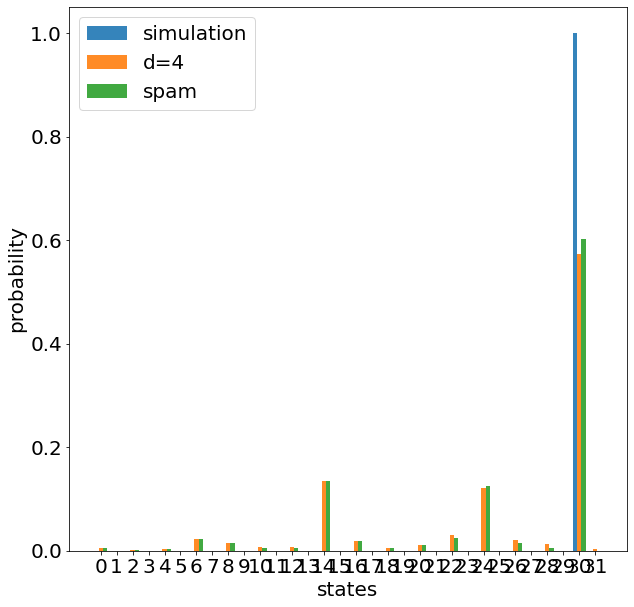

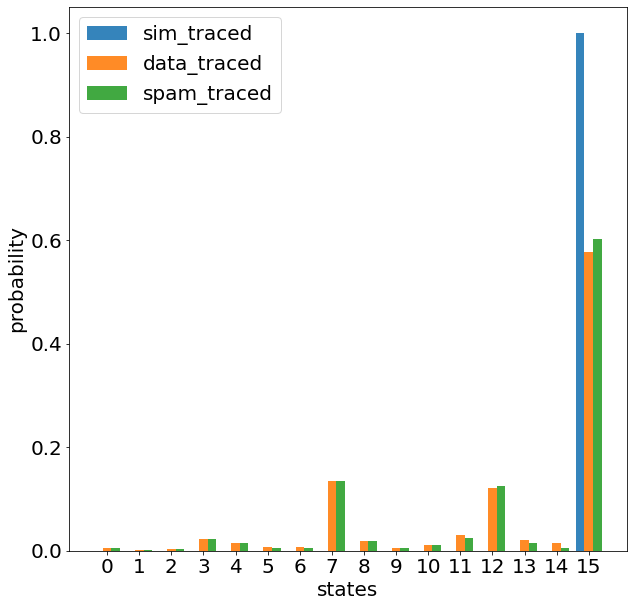

2023-04-24-170742_Line_005.txt
HAD2:HAD3:CNOT25:CNOT34:SKAX1+1.0000:SKAX3+1.0000:XA230.2500+:SKAY2+1.0000:SKAX1+1.0000:XA230.2500+:SKAY2+1.0000:SKAX5+1.0000:SKAX4+1.0000:AZ3+1.0000:XA230.2500+:SKAX2+1.0000:SKAY3+1.0000:XA230.2500+:AZ2+1.0000:SKAX3+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2



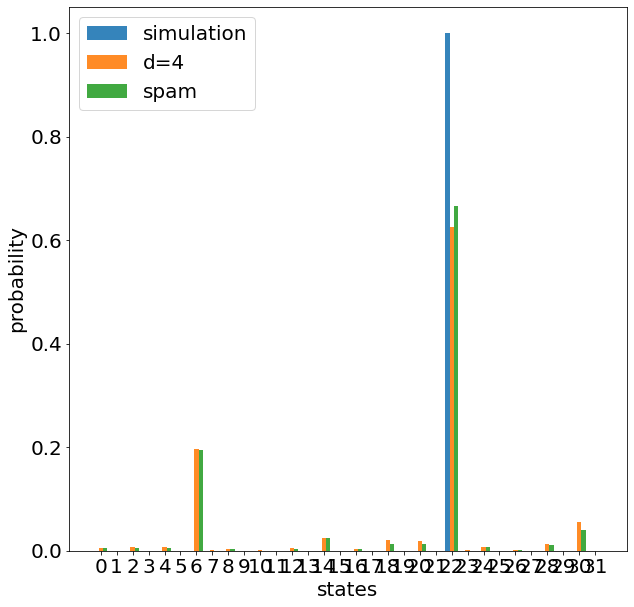

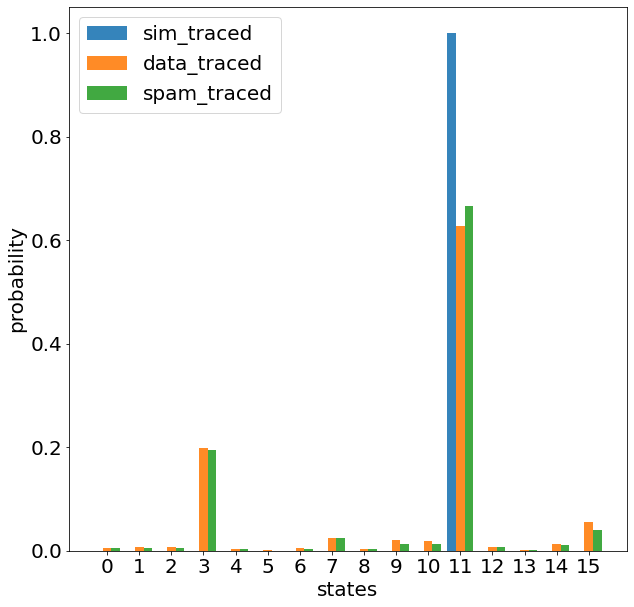

2023-04-24-170828_Line_006.txt
HAD2:HAD3:CNOT25:CNOT34:SKAX2+1.0000:AZ3+1.0000:XA230.2500+:SKAY2+1.0000:SKAX3+1.0000:XA230.2500+:SKAX2+1.0000:SKAX5+1.0000:SKAX4+1.0000:SKAX3+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:SKAY2+1.0000:SKAY3+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2



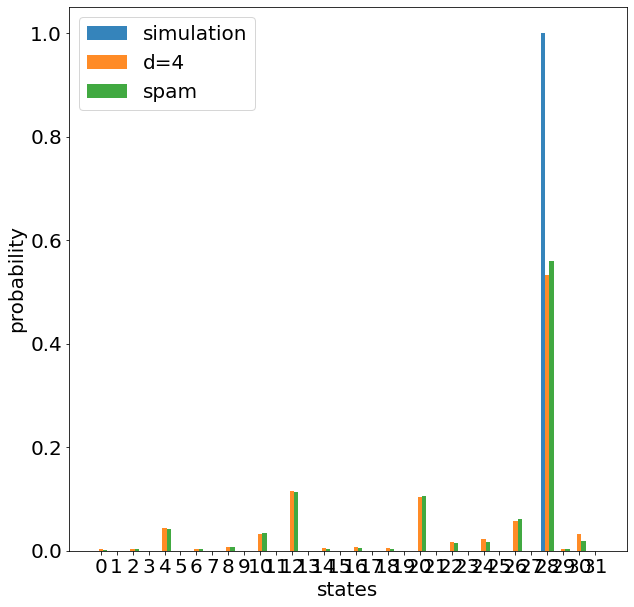

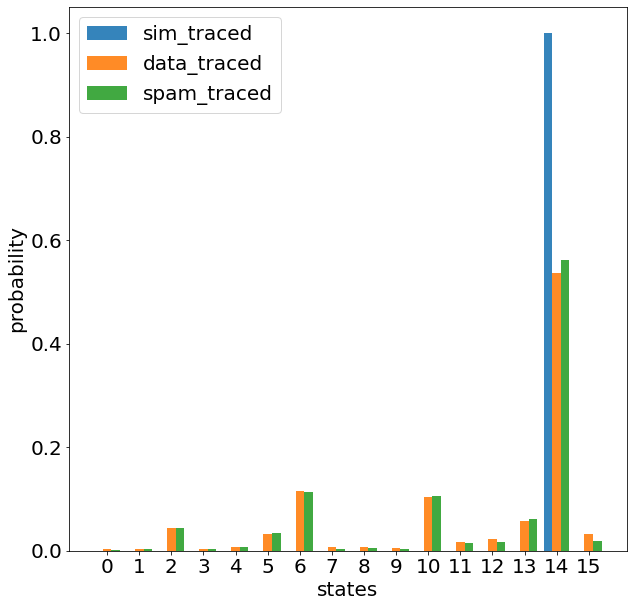

2023-04-24-170913_Line_007.txt
HAD2:HAD3:CNOT25:CNOT34:SKAX2+1.0000:AZ3+1.0000:XA230.2500+:SKAX2+1.0000:SKAY3+1.0000:XA230.2500+:AZ2+1.0000:SKAX5+1.0000:SKAX4+1.0000:SKAY3+1.0000:XA230.2500+:SKAX2+1.0000:SKAX1+1.0000:XA230.2500+:SKAX2+1.0000:AZ3+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2



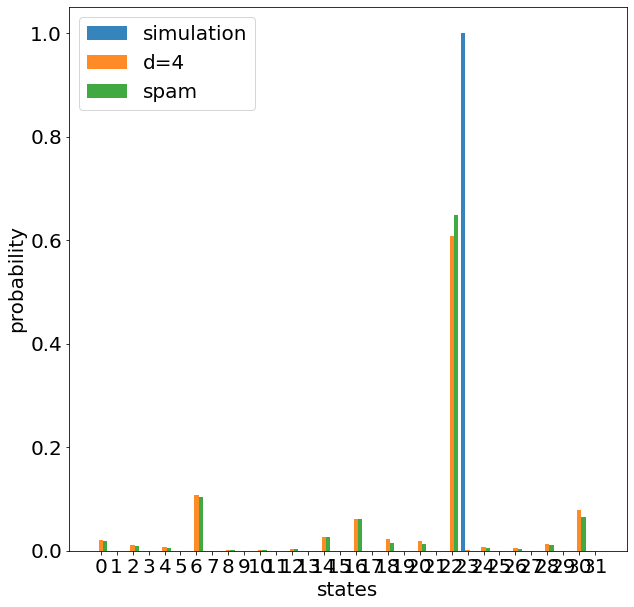

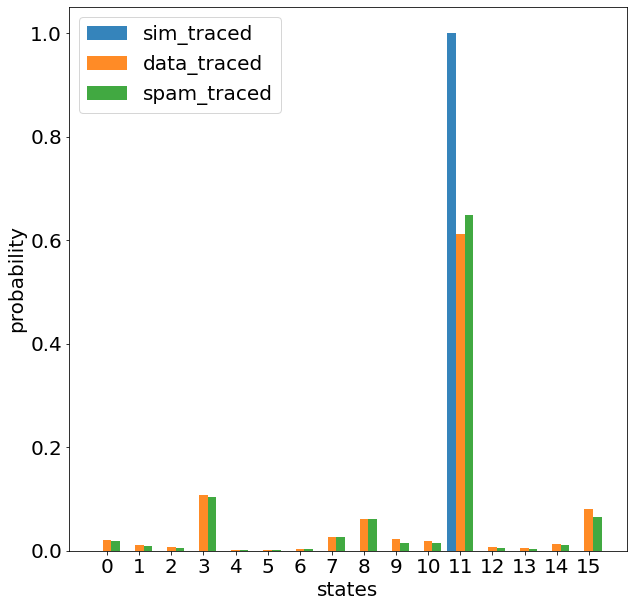

2023-04-24-171107_Line_008.txt
HAD2:HAD3:CNOT25:CNOT34:SKAX2+1.0000:SKAX1+1.0000:XA230.2500+:AZ2+1.0000:SKAX3+1.0000:XA230.2500+:AZ2+1.0000:SKAX5+1.0000:SKAX4+1.0000:AZ3+1.0000:XA230.2500+:AZ2+1.0000:SKAY3+1.0000:XA230.2500+:SKAY2+1.0000:SKAX1+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2



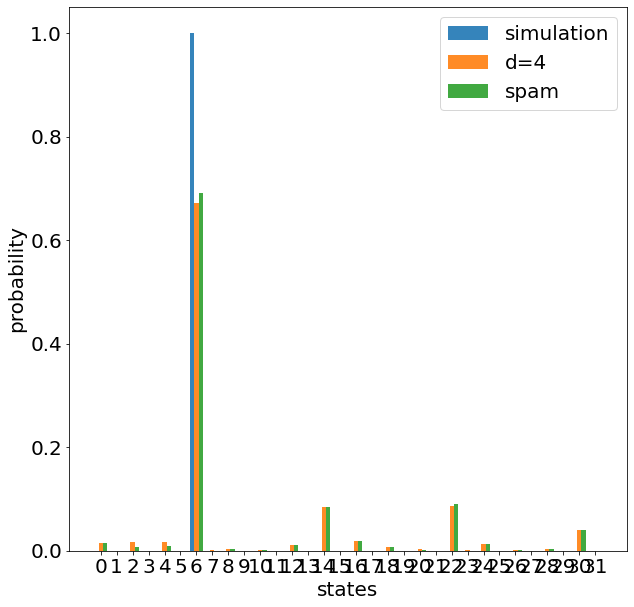

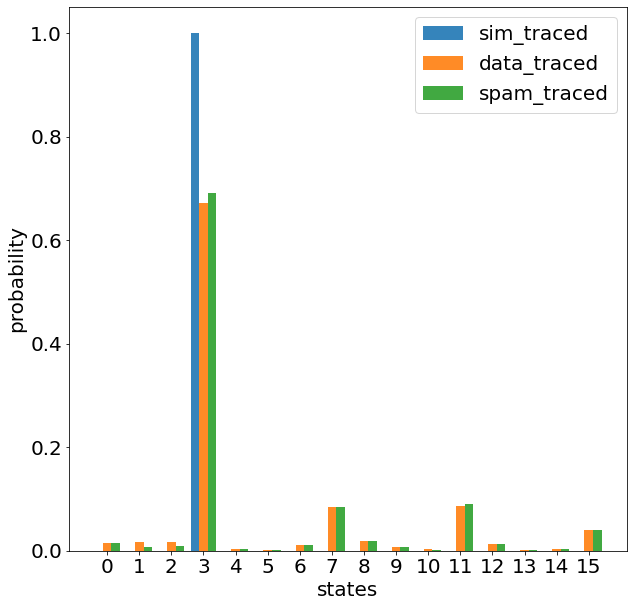

2023-04-24-171152_Line_009.txt
HAD2:HAD3:CNOT25:CNOT34:SKAY2+1.0000:AZ3+1.0000:XA230.2500+:AZ2+1.0000:SKAX1+1.0000:XA230.2500+:SKAX2+1.0000:SKAX5+1.0000:SKAX4+1.0000:SKAY3+1.0000:XA230.2500+:SKAX2+1.0000:SKAX1+1.0000:XA230.2500+:SKAX2+1.0000:AZ3+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2



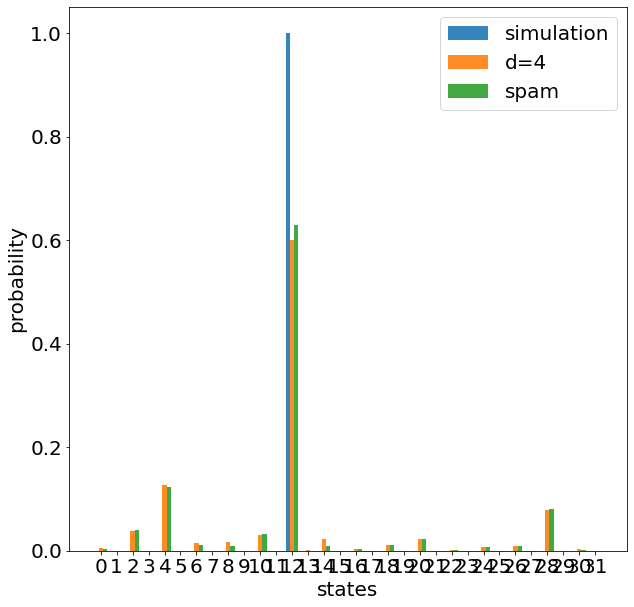

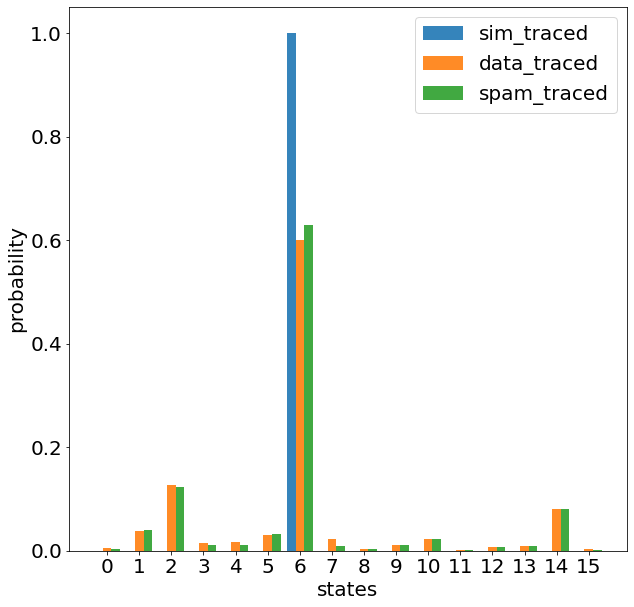

2023-04-24-171238_Line_010 ion dropped after this line.txt
HAD2:HAD3:CNOT25:CNOT34:SKAX2+1.0000:SKAX3+1.0000:XA230.2500+:SKAX2+1.0000:SKAX1+1.0000:XA230.2500+:SKAX2+1.0000:SKAX5+1.0000:SKAX4+1.0000:SKAX3+1.0000:XA230.2500+:SKAY2+1.0000:SKAX1+1.0000:XA230.2500+:AZ2+1.0000:SKAY3+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2


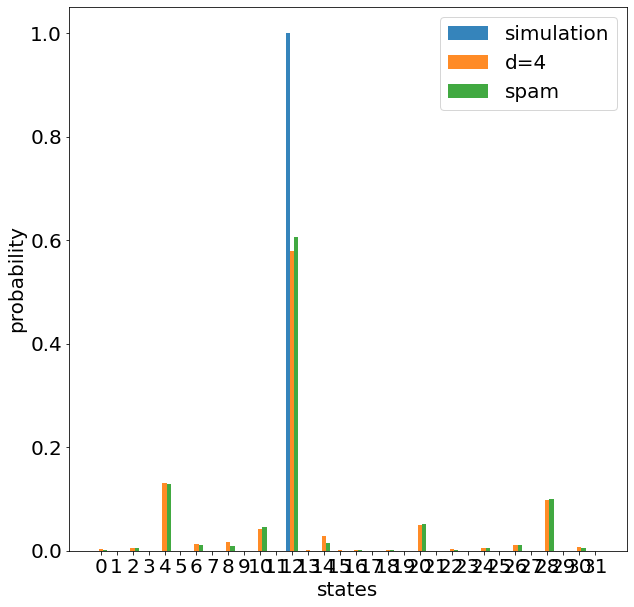

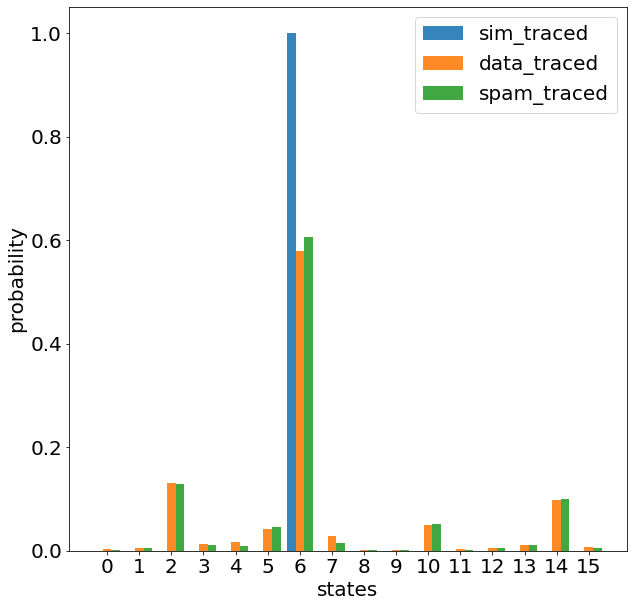

In [9]:
filenames_data=[]
counts_d4=[]
counts_d4_spam=[]
counts=[]
counts_spam=[]
filenames_data=filenames_d4.copy()
print (filenames_data)
# print (len(filenames_data))
paf_data=paf_data_d4
circuit=c_d4
for i in range (len(filenames_data)):
    print (filenames_data[i])
    a.Import(paf_data+filenames_data[i],keep_file=True)
    data_traced=Trace_Out(a,[0,1,2,3])
    counts=[round(shots*x) for x in  data_traced.population]
    counts_ibm_mapping, counts_ibm_mapping_dic=map_statepop_2_ibm_mapping(counts,nqubit)
    counts_d4.append(counts_ibm_mapping_dic)
    
    
    a_s=spam2.Correct_SPAM(a)
    data_traced_spam=Trace_Out(a_s,[0,1,2,3])
    counts_spam=[round(shots*x) for x in  data_traced_spam.population]
    counts_ibm_mapping_spam, counts_ibm_mapping_dic_spam=map_statepop_2_ibm_mapping(counts_spam,nqubit)
    counts_d4_spam.append(counts_ibm_mapping_dic_spam)

    b_c.Interpret_GatesLab_Sequence(circuit[i])
    print (circuit[i])
    b=b_c.Simulate()
    sim_traced=Trace_Out(b,[0,1,2,3])
    Display_States_Population(states=[b,a,a_s],label=["simulation","d=4","spam"])
    Display_States_Population(states=[sim_traced,data_traced,data_traced_spam],label=["sim_traced","data_traced","spam_traced"])
# #         

2023-04-24-174119_Line_001.txt
HAD2:HAD3:CNOT25:CNOT34:SKAX2+1.0000:SKAX3+1.0000:XA230.2500+:SKAX2+1.0000:SKAX1+1.0000:XA230.2500+:SKAX2+1.0000:SKAY3+1.0000:XA230.2500+:AZ2+1.0000:SKAX1+1.0000:XA230.2500+:AZ2+1.0000:SKAX5+1.0000:SKAX4+1.0000:SKAY3+1.0000:XA230.2500+:SKAX1+1.0000:AZ3+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:SKAX1+1.0000:AZ3+1.0000:XA230.2500+:SKAX2+1.0000:SKAX1+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2



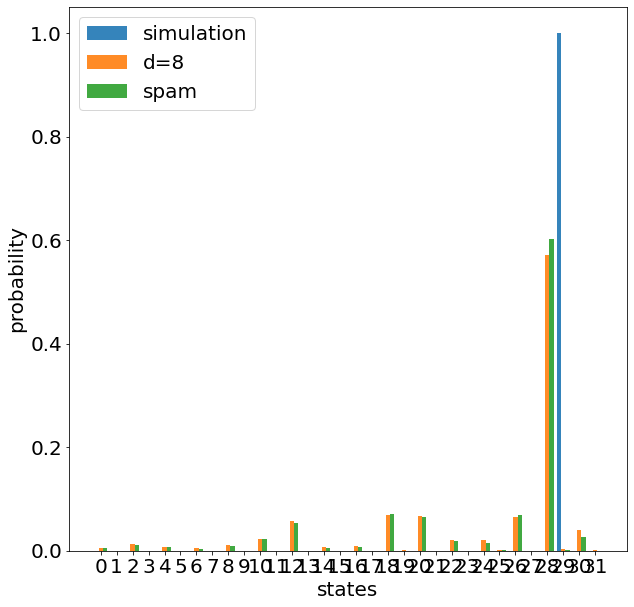

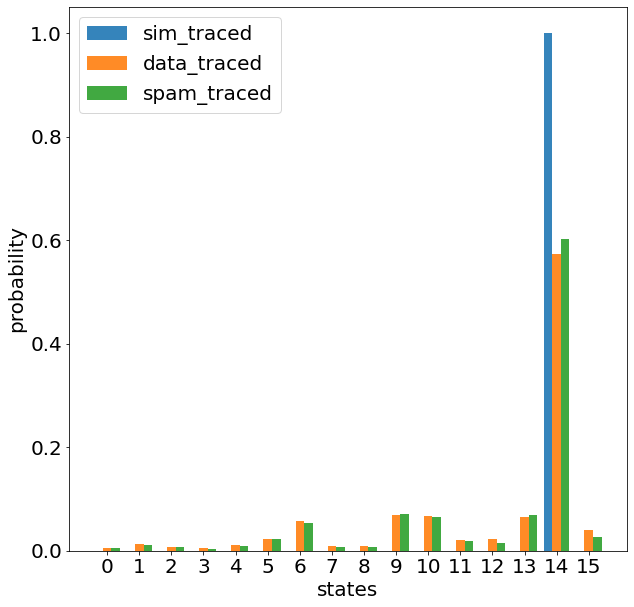

2023-04-24-174216_Line_002.txt
HAD2:HAD3:CNOT25:CNOT34:SKAX1+1.0000:SKAY3+1.0000:XA230.2500+:SKAX2+1.0000:AZ3+1.0000:XA230.2500+:AZ2+1.0000:SKAY3+1.0000:XA230.2500+:SKAX2+1.0000:AZ3+1.0000:XA230.2500+:SKAY2+1.0000:SKAX5+1.0000:SKAX4+1.0000:AZ3+1.0000:XA230.2500+:AZ2+1.0000:SKAY3+1.0000:XA230.2500+:SKAY2+1.0000:SKAY3+1.0000:XA230.2500+:SKAY2+1.0000:SKAX1+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2



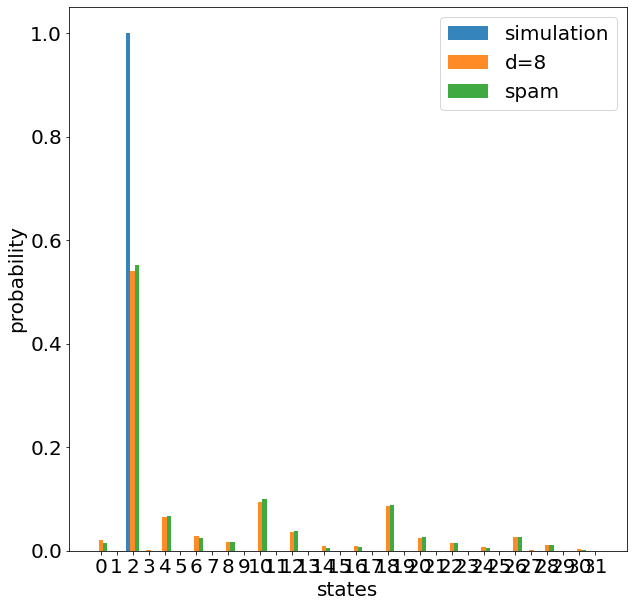

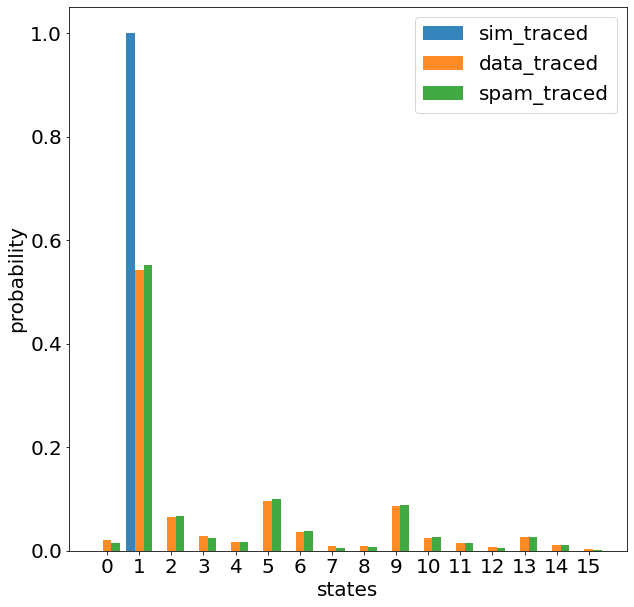

2023-04-24-174316_Line_003.txt
HAD2:HAD3:CNOT25:CNOT34:SKAY2+1.0000:AZ3+1.0000:XA230.2500+:SKAY2+1.0000:SKAX1+1.0000:XA230.2500+:SKAX2+1.0000:AZ3+1.0000:XA230.2500+:SKAX2+1.0000:SKAY3+1.0000:XA230.2500+:AZ2+1.0000:SKAX5+1.0000:SKAX4+1.0000:SKAY3+1.0000:XA230.2500+:SKAX2+1.0000:SKAX3+1.0000:XA230.2500+:SKAX2+1.0000:SKAX3+1.0000:XA230.2500+:SKAY2+1.0000:SKAX1+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2



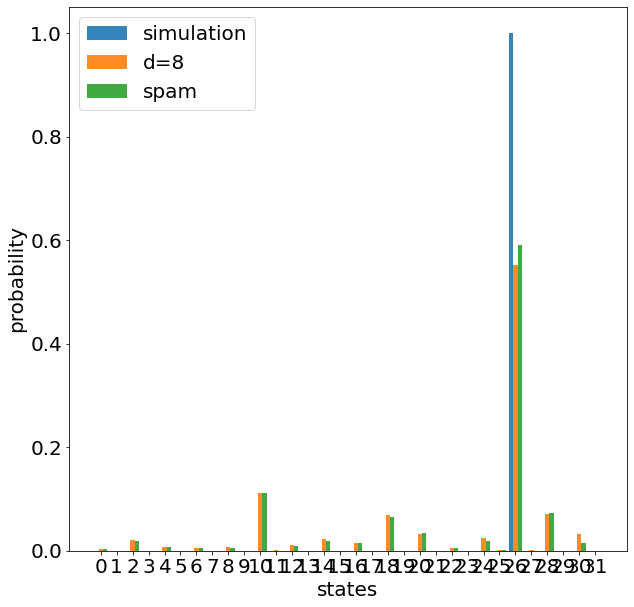

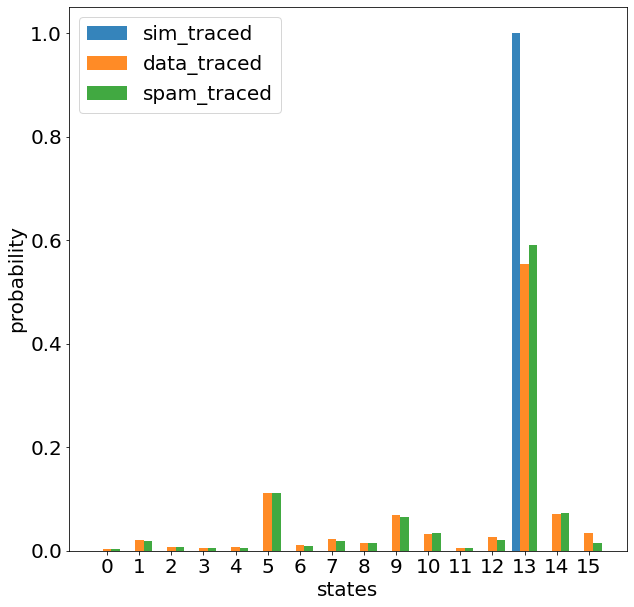

2023-04-24-174525_Line_004.txt
HAD2:HAD3:CNOT25:CNOT34:AZ2+1.0000:AZ3+1.0000:XA230.2500+:SKAY2+1.0000:AZ3+1.0000:XA230.2500+:SKAX2+1.0000:SKAX3+1.0000:XA230.2500+:SKAX1+1.0000:SKAX1+1.0000:XA230.2500+:SKAX2+1.0000:SKAX5+1.0000:SKAX4+1.0000:SKAY3+1.0000:XA230.2500+:AZ2+1.0000:SKAY3+1.0000:XA230.2500+:SKAY2+1.0000:AZ3+1.0000:XA230.2500+:SKAX1+1.0000:SKAX3+1.0000:XA230.2500+:AZ2+1.0000:SKAX3+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2



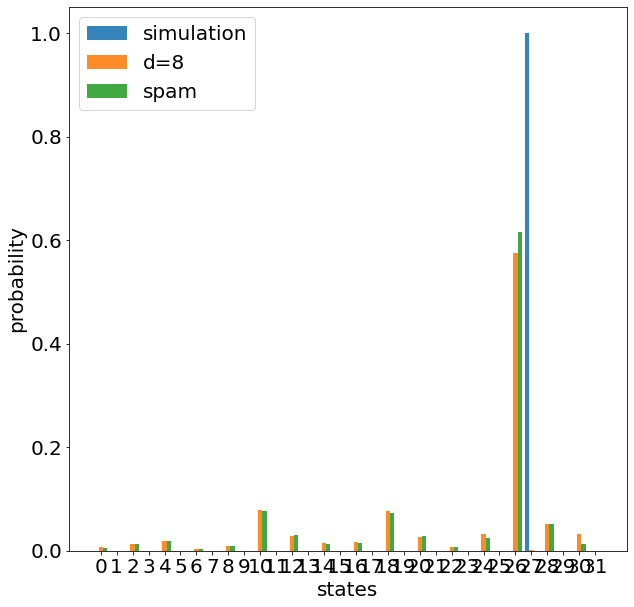

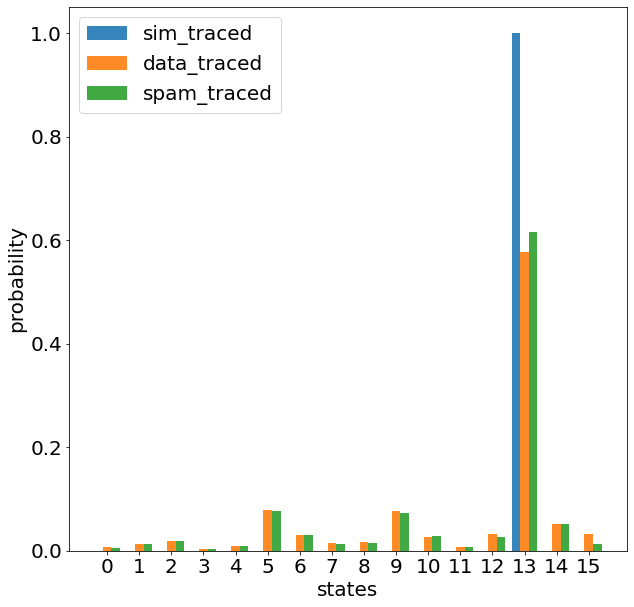

2023-04-24-174627_Line_005.txt
HAD2:HAD3:CNOT25:CNOT34:SKAX1+1.0000:AZ3+1.0000:XA230.2500+:SKAY2+1.0000:SKAX1+1.0000:XA230.2500+:SKAX1+1.0000:SKAX3+1.0000:XA230.2500+:SKAX1+1.0000:SKAX3+1.0000:XA230.2500+:AZ2+1.0000:SKAX5+1.0000:SKAX4+1.0000:SKAX1+1.0000:XA230.2500+:SKAX2+1.0000:SKAX3+1.0000:XA230.2500+:SKAX2+1.0000:SKAY3+1.0000:XA230.2500+:AZ2+1.0000:SKAY3+1.0000:XA230.2500+:SKAY2+1.0000:SKAX3+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2



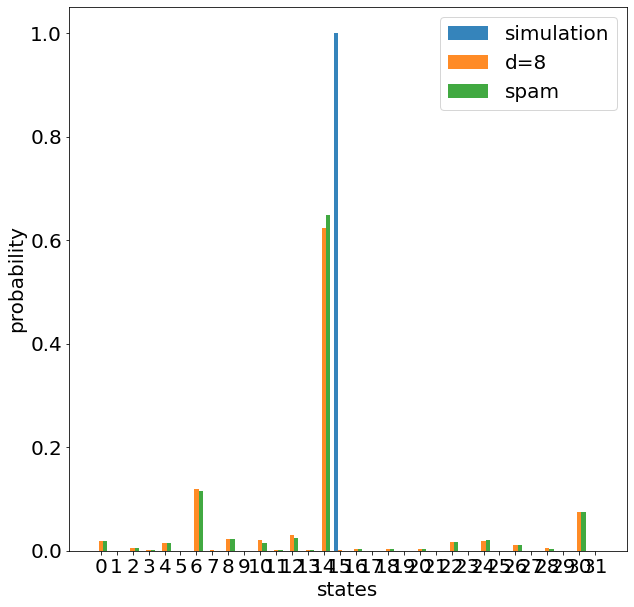

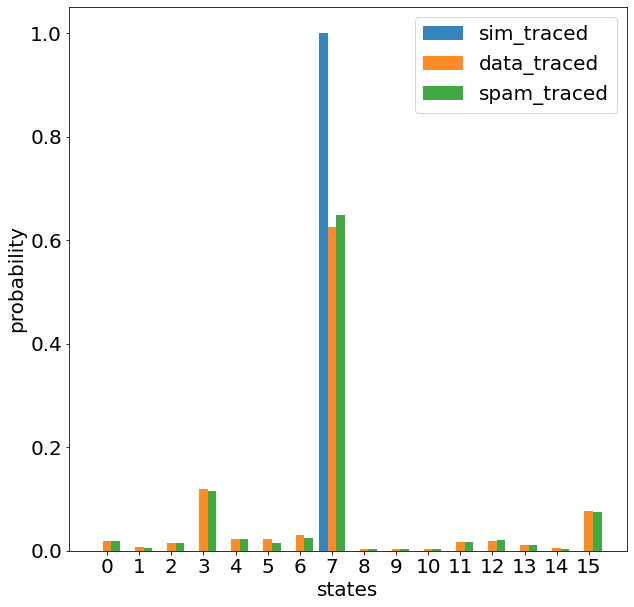

2023-04-24-174727_Line_006.txt
HAD2:HAD3:CNOT25:CNOT34:AZ2+1.0000:AZ3+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:AZ2+1.0000:SKAY3+1.0000:XA230.2500+:SKAX2+1.0000:SKAX1+1.0000:XA230.2500+:SKAX1+1.0000:SKAX5+1.0000:SKAX4+1.0000:SKAY3+1.0000:XA230.2500+:SKAX2+1.0000:SKAY3+1.0000:XA230.2500+:SKAY2+1.0000:SKAX1+1.0000:XA230.2500+:SKAX1+1.0000:SKAY3+1.0000:XA230.2500+:AZ2+1.0000:SKAX1+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2



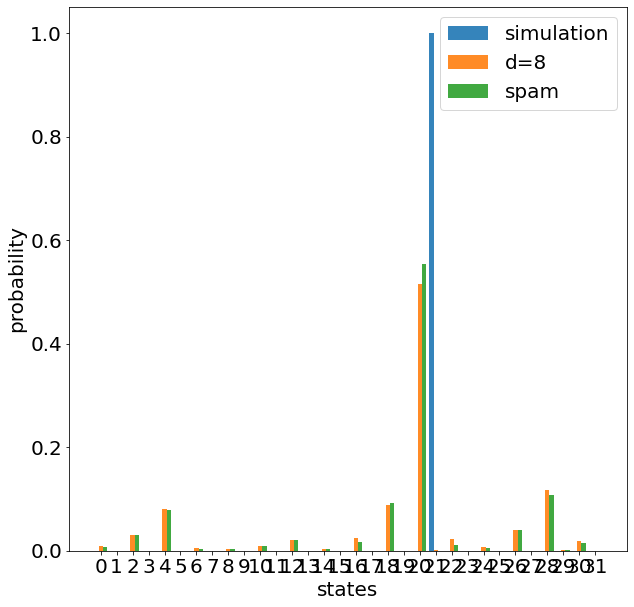

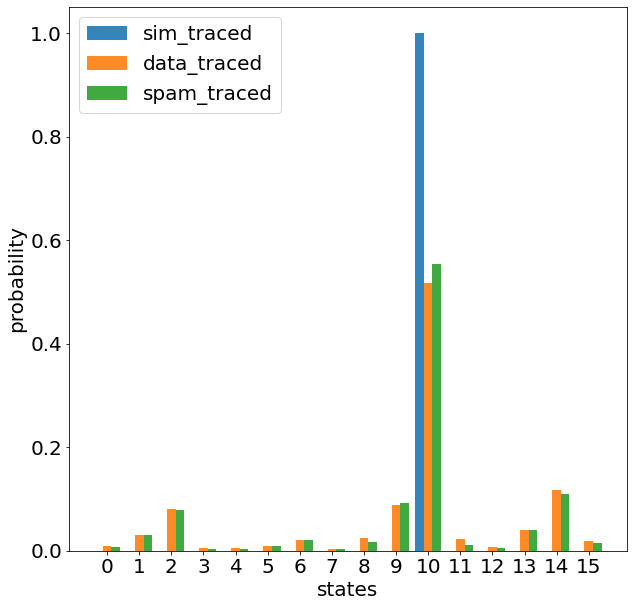

2023-04-24-174937_Line_007.txt
HAD2:HAD3:CNOT25:CNOT34:SKAX1+1.0000:AZ3+1.0000:XA230.2500+:SKAX1+1.0000:AZ3+1.0000:XA230.2500+:SKAX1+1.0000:SKAX3+1.0000:XA230.2500+:SKAY2+1.0000:AZ3+1.0000:XA230.2500+:SKAX1+1.0000:SKAX5+1.0000:SKAX4+1.0000:SKAX1+1.0000:XA230.2500+:SKAX1+1.0000:AZ3+1.0000:XA230.2500+:SKAX2+1.0000:SKAY3+1.0000:XA230.2500+:SKAY2+1.0000:SKAX3+1.0000:XA230.2500+:SKAY2+1.0000:SKAY3+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2



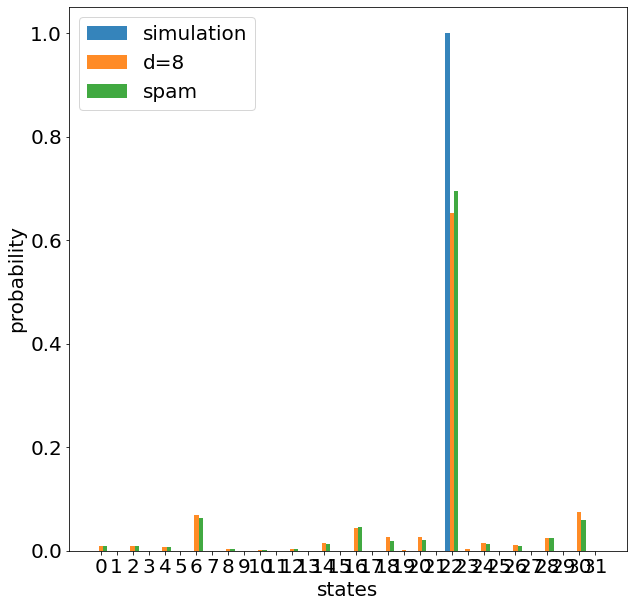

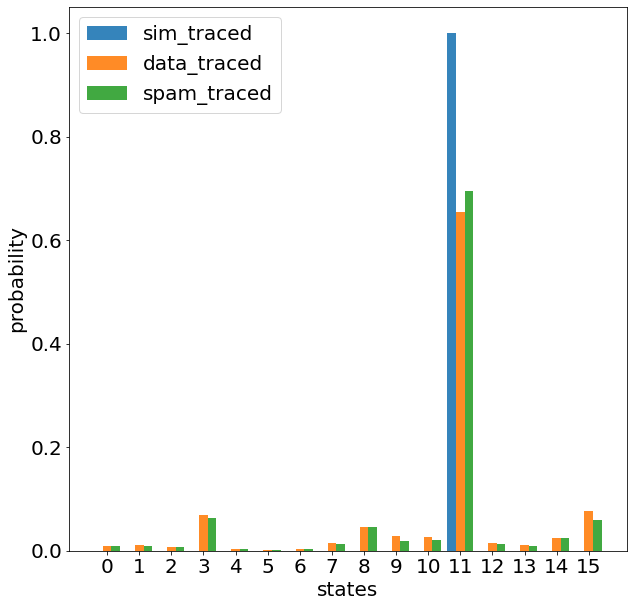

2023-04-24-175039_Line_008.txt
HAD2:HAD3:CNOT25:CNOT34:SKAX2+1.0000:SKAY3+1.0000:XA230.2500+:SKAX2+1.0000:SKAX1+1.0000:XA230.2500+:SKAY2+1.0000:SKAX3+1.0000:XA230.2500+:AZ2+1.0000:SKAY3+1.0000:XA230.2500+:SKAX2+1.0000:SKAX5+1.0000:SKAX4+1.0000:SKAX1+1.0000:XA230.2500+:SKAX2+1.0000:SKAX3+1.0000:XA230.2500+:AZ2+1.0000:SKAX3+1.0000:XA230.2500+:SKAX1+1.0000:SKAY3+1.0000:XA230.2500+:SKAY2+1.0000:SKAX3+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2



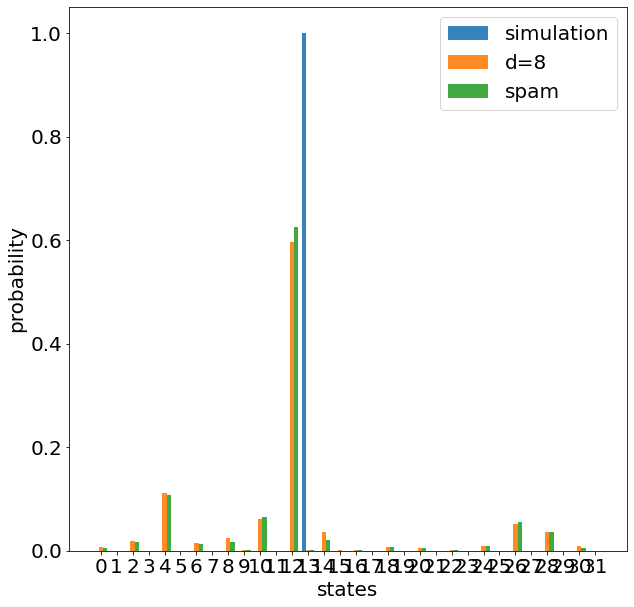

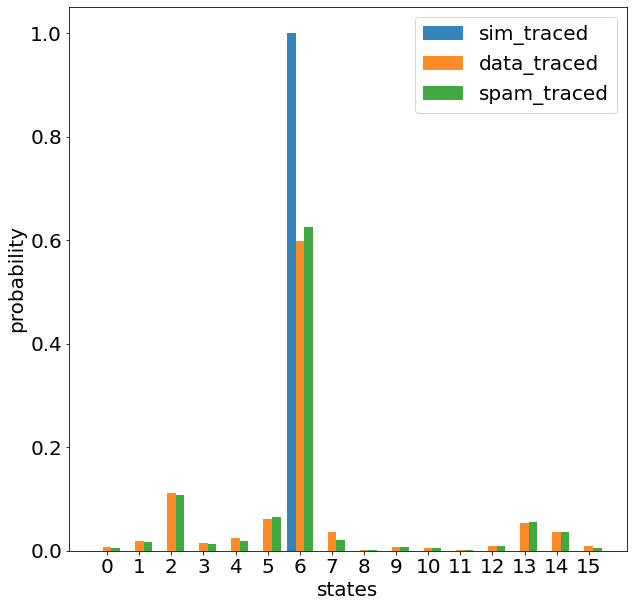

2023-04-24-175138_Line_009.txt
HAD2:HAD3:CNOT25:CNOT34:SKAX2+1.0000:AZ3+1.0000:XA230.2500+:SKAY2+1.0000:AZ3+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:SKAX1+1.0000:SKAX3+1.0000:XA230.2500+:AZ2+1.0000:SKAX5+1.0000:SKAX4+1.0000:SKAY3+1.0000:XA230.2500+:SKAX1+1.0000:AZ3+1.0000:XA230.2500+:SKAX2+1.0000:SKAX3+1.0000:XA230.2500+:SKAX2+1.0000:SKAY3+1.0000:XA230.2500+:SKAX2+1.0000:SKAX3+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2



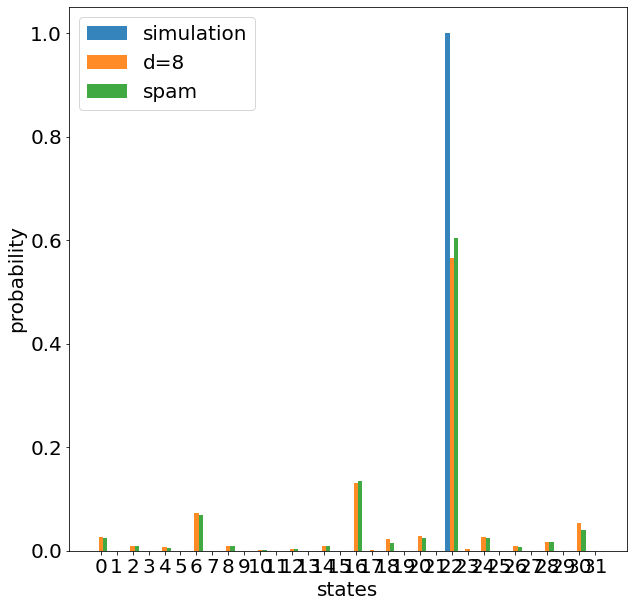

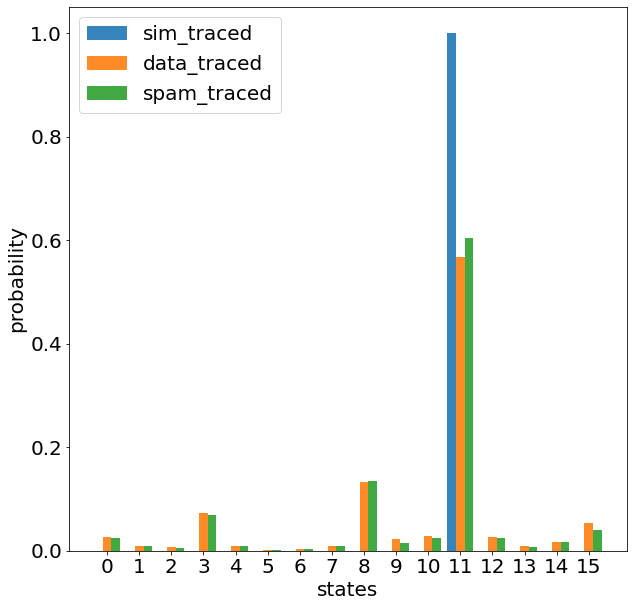

2023-04-24-175348_Line_010.txt
HAD2:HAD3:CNOT25:CNOT34:SKAY2+1.0000:SKAY3+1.0000:XA230.2500+:AZ2+1.0000:SKAY3+1.0000:XA230.2500+:AZ2+1.0000:SKAX1+1.0000:XA230.2500+:SKAY2+1.0000:SKAX1+1.0000:XA230.2500+:SKAX1+1.0000:SKAX5+1.0000:SKAX4+1.0000:SKAX1+1.0000:XA230.2500+:SKAY2+1.0000:SKAX3+1.0000:XA230.2500+:SKAX1+1.0000:SKAY3+1.0000:XA230.2500+:SKAY2+1.0000:SKAX3+1.0000:XA230.2500+:SKAX2+1.0000:AZ3+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2


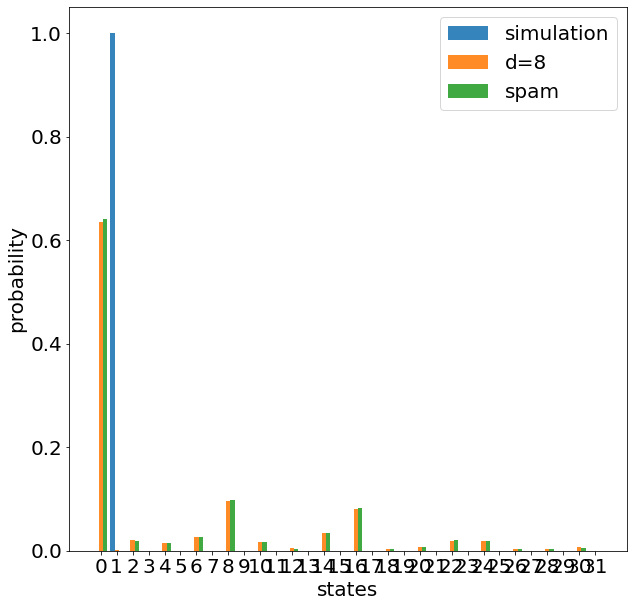

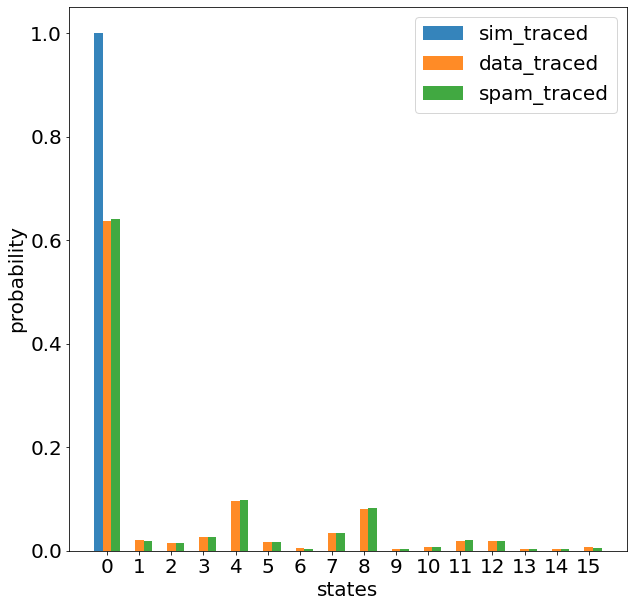

In [10]:
filenames_data=[]
counts_d8=[]
counts_d8_spam=[]
counts=[]
counts_spam=[]
filenames_data=filenames_d8.copy()
# print (filenames_data)
# # print (len(filenames_data))
paf_data=paf_data_d8
circuit=c_d8
for i in range (len(filenames_data)):
    print (filenames_data[i])
    a.Import(paf_data+filenames_data[i],keep_file=True)
    data_traced=Trace_Out(a,[0,1,2,3])
    counts=[round(shots*x) for x in  data_traced.population]
    counts_ibm_mapping, counts_ibm_mapping_dic=map_statepop_2_ibm_mapping(counts,nqubit)
    counts_d8.append(counts_ibm_mapping_dic)
    
    a_s=spam2.Correct_SPAM(a)
    data_traced_spam=Trace_Out(a_s,[0,1,2,3])
    counts_spam=[round(shots*x) for x in  data_traced_spam.population]
    counts_ibm_mapping_spam, counts_ibm_mapping_dic_spam=map_statepop_2_ibm_mapping(counts_spam,nqubit)
    counts_d8_spam.append(counts_ibm_mapping_dic_spam)
    
    b_c.Interpret_GatesLab_Sequence(circuit[i])
    print (circuit[i])
    b=b_c.Simulate()
    sim_traced=Trace_Out(b,[0,1,2,3])
    Display_States_Population(states=[b,a,a_s],label=["simulation","d=8","spam"])
    Display_States_Population(states=[sim_traced,data_traced,data_traced_spam],label=["sim_traced","data_traced","spam_traced"])

In [11]:
# print (counts_d2[0])
# print (counts_d2_spam[0])

In [12]:
import copy
from copy import copy, deepcopy

# copy.copy(x)
# copy.deepcopy(x)

picklefile="d554e8f2-9319-4d67-a087-4e2955e924d6XX23541withpadding"
with open("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/circuits/23541 EAB XX C=10 0424 /"+picklefile, "rb") as fp:   # Unpickling
    eab_load = pickle.load(fp)
print (picklefile)
# print (b)

# with open("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/circuits/23541 EAB XX C=10 0424 /"+picklefile, "rb") as fp:   # Unpickling
#     eab_load_2 = pickle.load(fp)
# print (picklefile)

# with open("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/circuits/23541 EAB XX C=10 0424 /"+picklefile, "rb") as fp:   # Unpickling
#     eab_load_3 = pickle.load(fp)
# print (picklefile)


C=10
eab_load_cpy=deepcopy(eab_load)
eab_load_cpy_spam=deepcopy(eab_load)
eab_load_cpy_24=deepcopy(eab_load[0:20]) #a copy that only has depth=[2,4]


d554e8f2-9319-4d67-a087-4e2955e924d6XX23541withpadding


In [13]:
for i in range (C):
#     print (i)
    assert eab_load_cpy[i]["L"]==2
    eab_load_cpy[i]["counts"]=counts_d2[i].copy()


    
for i in range (C):
#     print (i)
    assert eab_load_cpy_spam[i]["L"]==2
    eab_load_cpy_spam[i]["counts"]=counts_d2_spam[i].copy()



for i in range (C):
    print (eab_load_cpy[i]["counts"])
    print (eab_load_cpy_spam[i]["counts"])

{'0000': 8, '1000': 52, '0100': 5, '1100': 6, '0010': 10, '1010': 270, '0110': 16, '1110': 23, '0001': 34, '1001': 283, '0101': 46, '1101': 15, '0011': 70, '1011': 2929, '0111': 131, '1111': 102}
{'0000': 7, '1000': 47, '0100': 4, '1100': 6, '0010': 6, '1010': 252, '0110': 15, '1110': 15, '0001': 31, '1001': 262, '0101': 47, '1101': 13, '0011': 36, '1011': 3119, '0111': 134, '1111': 6}
{'0000': 11, '1000': 266, '0100': 18, '1100': 32, '0010': 19, '1010': 23, '0110': 12, '1110': 11, '0001': 93, '1001': 3093, '0101': 19, '1101': 109, '0011': 62, '1011': 211, '0111': 11, '1111': 10}
{'0000': 7, '1000': 235, '0100': 18, '1100': 30, '0010': 19, '1010': 21, '0110': 12, '1110': 10, '0001': 60, '1001': 3233, '0101': 19, '1101': 103, '0011': 60, '1011': 162, '0111': 9, '1111': 1}
{'0000': 243, '1000': 11, '0100': 33, '1100': 96, '0010': 47, '1010': 14, '0110': 5, '1110': 15, '0001': 2867, '1001': 45, '0101': 58, '1101': 110, '0011': 302, '1011': 71, '0111': 5, '1111': 78}
{'0000': 210, '1000': 

In [14]:
for i in range (C,2*C):
#     print (i)
    assert eab_load_cpy[i]["L"]==4
    eab_load_cpy[i]["counts"]=counts_d4[i-10].copy()
#     print ( eab_load_cpy[i]["counts_exp"])
#     print (eab_load_cpy[i]["counts"])
    
for i in range (C,2*C):
#     print (i)
    assert eab_load_cpy_spam[i]["L"]==4
    eab_load_cpy_spam[i]["counts"]=counts_d4_spam[i-10].copy()
#     print ( eab_load_cpy[i]["counts_exp"])
#     print (eab_load_cpy_spam[i]["counts"])

for i in range (C,2*C):
    print (eab_load_cpy[i]["counts"])
    print (eab_load_cpy_spam[i]["counts"])    

{'0000': 80, '1000': 84, '0100': 2392, '1100': 55, '0010': 17, '1010': 55, '0110': 334, '1110': 57, '0001': 34, '1001': 52, '0101': 564, '1101': 26, '0011': 16, '1011': 55, '0111': 155, '1111': 24}
{'0000': 47, '1000': 85, '0100': 2478, '1100': 2, '0010': 13, '1010': 58, '0110': 340, '1110': 50, '0001': 26, '1001': 53, '0101': 598, '1101': 14, '0011': 14, '1011': 58, '0111': 146, '1111': 19}
{'0000': 214, '1000': 19, '0100': 15, '1100': 10, '0010': 453, '1010': 31, '0110': 27, '1110': 40, '0001': 343, '1001': 59, '0101': 18, '1101': 34, '0011': 2384, '1011': 104, '0111': 75, '1111': 174}
{'0000': 206, '1000': 18, '0100': 15, '1100': 9, '0010': 442, '1010': 30, '0110': 17, '1110': 39, '0001': 327, '1001': 59, '0101': 17, '1101': 34, '0011': 2488, '1011': 101, '0111': 19, '1111': 179}
{'0000': 93, '1000': 26, '0100': 2572, '1100': 62, '0010': 23, '1010': 21, '0110': 386, '1110': 75, '0001': 34, '1001': 48, '0101': 454, '1101': 21, '0011': 9, '1011': 23, '0111': 128, '1111': 25}
{'0000': 

In [15]:
# filename=""
for i in range (2*C,3*C):
#     print (i)
    assert eab_load_cpy[i]["L"]==8
    eab_load_cpy[i]["counts"]=counts_d8[i-20].copy()
# filename+="0424eabXX_C10_248_23541"
# with open("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/"+filename, "wb") as fp:
#     pickle.dump(eab_load_cpy, fp)




for i in range (2*C,3*C):
#     print (i)
    assert eab_load_cpy_spam[i]["L"]==8
    eab_load_cpy_spam[i]["counts"]=counts_d8_spam[i-20].copy()
#     print ( eab_load_cpy[i]["counts_exp"])
#     print (eab_load_cpy_spam[i]["counts"])

for i in range (2*C,3*C):
    print (eab_load_cpy[i]["counts"])
    print (eab_load_cpy_spam[i]["counts"])    

{'0000': 20, '1000': 52, '0100': 33, '1100': 19, '0010': 43, '1010': 91, '0110': 228, '1110': 34, '0001': 37, '1001': 277, '0101': 271, '1101': 82, '0011': 89, '1011': 265, '0111': 2295, '1111': 164}
{'0000': 18, '1000': 48, '0100': 28, '1100': 18, '0010': 40, '1010': 94, '0110': 211, '1110': 26, '0001': 31, '1001': 286, '0101': 264, '1101': 79, '0011': 61, '1011': 277, '0111': 2411, '1111': 108}
{'0000': 86, '1000': 2171, '0100': 263, '1100': 113, '0010': 69, '1010': 381, '0110': 147, '1110': 34, '0001': 36, '1001': 345, '0101': 102, '1101': 60, '0011': 27, '1011': 109, '0111': 44, '1111': 13}
{'0000': 57, '1000': 2208, '0100': 267, '1100': 102, '0010': 65, '1010': 398, '0110': 150, '1110': 19, '0001': 31, '1001': 355, '0101': 107, '1101': 59, '0011': 25, '1011': 106, '0111': 42, '1111': 8}
{'0000': 17, '1000': 85, '0100': 33, '1100': 25, '0010': 28, '1010': 447, '0110': 41, '1110': 89, '0001': 61, '1001': 277, '0101': 133, '1101': 22, '0011': 106, '1011': 2215, '0111': 287, '1111': 1

In [16]:
for i in range (C):
    assert eab_load_cpy_24[i]["L"]==2
    eab_load_cpy_24[i]["counts"]=counts_d2[i].copy()

for i in range (C,2*C):
    assert eab_load_cpy_24[i]["L"]==4
    eab_load_cpy_24[i]["counts"]=counts_d4[i-10].copy()

print (eab_load_cpy_24) 

[{'n': 2, 'L': 2, 'clifford': {'stabilizer': ['+IZ', '-ZI'], 'destabilizer': ['-IX', '-XI']}, 'clifford_layer': 'XX', 'circuit': 'HAD2:HAD3:CNOT25:CNOT34:SKAY2+1.0000:AZ3+1.0000:XA230.2500+:SKAY2+1.0000:SKAX5+1.0000:SKAX4+1.0000:AZ3+1.0000:XA230.2500+:SKAY2+1.0000:AZ3+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2', 'counts': {'0000': 8, '1000': 52, '0100': 5, '1100': 6, '0010': 10, '1010': 270, '0110': 16, '1110': 23, '0001': 34, '1001': 283, '0101': 46, '1101': 15, '0011': 70, '1011': 2929, '0111': 131, '1111': 102}}, {'n': 2, 'L': 2, 'clifford': {'stabilizer': ['+IZ', '-ZI'], 'destabilizer': ['-IX', '+XI']}, 'clifford_layer': 'XX', 'circuit': 'HAD2:HAD3:CNOT25:CNOT34:SKAY2+1.0000:SKAX3+1.0000:XA230.2500+:SKAY2+1.0000:SKAX5+1.0000:SKAX4+1.0000:SKAX3+1.0000:XA230.2500+:AZ2+1.0000:SKAX3+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2', 'counts': {'0000': 11, '1000': 266, '0100': 18, '1100': 32, '0010': 19, '1010': 23, '0110': 12, '1110': 11, '0001': 93, '1001': 3093,

In [17]:
eab_load_cpy_24_spam=deepcopy(eab_load[0:20]) #a copy that only has depth=[2,4]
for i in range (C):
    assert eab_load_cpy_24_spam[i]["L"]==2
    eab_load_cpy_24_spam[i]["counts"]=counts_d2_spam[i].copy()

for i in range (C,2*C):
    assert eab_load_cpy_24_spam[i]["L"]==4
    eab_load_cpy_24_spam[i]["counts"]=counts_d4_spam[i-10].copy()

print (eab_load_cpy_24_spam) 

[{'n': 2, 'L': 2, 'clifford': {'stabilizer': ['+IZ', '-ZI'], 'destabilizer': ['-IX', '-XI']}, 'clifford_layer': 'XX', 'circuit': 'HAD2:HAD3:CNOT25:CNOT34:SKAY2+1.0000:AZ3+1.0000:XA230.2500+:SKAY2+1.0000:SKAX5+1.0000:SKAX4+1.0000:AZ3+1.0000:XA230.2500+:SKAY2+1.0000:AZ3+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2', 'counts': {'0000': 7, '1000': 47, '0100': 4, '1100': 6, '0010': 6, '1010': 252, '0110': 15, '1110': 15, '0001': 31, '1001': 262, '0101': 47, '1101': 13, '0011': 36, '1011': 3119, '0111': 134, '1111': 6}}, {'n': 2, 'L': 2, 'clifford': {'stabilizer': ['+IZ', '-ZI'], 'destabilizer': ['-IX', '+XI']}, 'clifford_layer': 'XX', 'circuit': 'HAD2:HAD3:CNOT25:CNOT34:SKAY2+1.0000:SKAX3+1.0000:XA230.2500+:SKAY2+1.0000:SKAX5+1.0000:SKAX4+1.0000:SKAX3+1.0000:XA230.2500+:AZ2+1.0000:SKAX3+1.0000:SKAX4+1.0000:CNOT34:SKAX5+1.0000:CNOT25:HAD3:HAD2', 'counts': {'0000': 7, '1000': 235, '0100': 18, '1100': 30, '0010': 19, '1010': 21, '0110': 12, '1110': 10, '0001': 60, '1001': 3233, '01

In [18]:
sys.path.append(r"/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation")
import EAB_process_modified 
import itertools
import pdb

'''Specify a set of Pauli you want to estimate'''
# C=10
depth=[2,4,8]
pauli_request_list = [''.join(s) for s in itertools.product(['I','X','Y','Z'], repeat = nqubit)] #full

#process_EAB(Lrange, cb_data, pauli_request_list)
eab_result=EAB_process_modified.process_EAB(depth, eab_load_cpy, pauli_request_list)
# eab_result_spam=EAB_process_modified.process_EAB(depth, eab_load_cpy_spam, pauli_request_list)

print (eab_result)


{'fidelity_list': {'II': {2: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 4: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 8: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}, 'IX': {2: [0.805, 0.804, 0.768, 0.65, 0.571, 0.5195, 0.782, 0.4035, 0.8345, 0.4805], 4: [0.537, 0.5955, 0.629, 0.6, 0.494, 0.566, 0.6375, 0.65, 0.7175, 0.6445], 8: [0.74, 0.632, 0.6175, 0.645, 0.724, 0.672, 0.76, 0.748, 0.7175, 0.7095]}, 'IY': {2: [0.683, 0.766, 0.717, 0.6115, 0.4775, 0.5005, 0.7365, 0.3595, 0.806, 0.445], 4: [0.4975, 0.491, 0.6045, 0.3285, 0.4635, 0.476, 0.5155, 0.6535, 0.5945, 0.549], 8: [0.509, 0.463, 0.4235, 0.5415, 0.6555, 0.458, 0.6165, 0.6675, 0.4325, 0.618]}, 'IZ': {2: [0.828, 0.889, 0.8, 0.8905, 0.8585, 0.933, 0.8695, 0.887, 0.9045, 0.8635], 4: [0.8035, 0.8035, 0.8615, 0.6035, 0.8965, 0.723, 0.741, 0.8405, 0.749, 0.8235], 8: [0.563, 0.612, 0.618, 0.6275, 0.7855, 0.574, 0.7515, 0.6295, 0.524, 0.7615]}, 'XI': {2: [0.7755, 0.8205, 0.7315, 0.8785, 0.8385, 0.8195, 0.8295, 0.76

In [19]:
depth=[2,4,8]
eab_result_spam=EAB_process_modified.process_EAB(depth, eab_load_cpy_spam, pauli_request_list)
# print (eab_result_spam)

depth=[2,4]
eab_result_24=EAB_process_modified.process_EAB(depth, eab_load_cpy_24, pauli_request_list)
print (eab_result_24)

depth=[2,4]
eab_result_24_spam=EAB_process_modified.process_EAB(depth, eab_load_cpy_24_spam, pauli_request_list)

{'fidelity_list': {'II': {2: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 4: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}, 'IX': {2: [0.805, 0.804, 0.768, 0.65, 0.571, 0.5195, 0.782, 0.4035, 0.8345, 0.4805], 4: [0.537, 0.5955, 0.629, 0.6, 0.494, 0.566, 0.6375, 0.65, 0.7175, 0.6445]}, 'IY': {2: [0.683, 0.766, 0.717, 0.6115, 0.4775, 0.5005, 0.7365, 0.3595, 0.806, 0.445], 4: [0.4975, 0.491, 0.6045, 0.3285, 0.4635, 0.476, 0.5155, 0.6535, 0.5945, 0.549]}, 'IZ': {2: [0.828, 0.889, 0.8, 0.8905, 0.8585, 0.933, 0.8695, 0.887, 0.9045, 0.8635], 4: [0.8035, 0.8035, 0.8615, 0.6035, 0.8965, 0.723, 0.741, 0.8405, 0.749, 0.8235]}, 'XI': {2: [0.7755, 0.8205, 0.7315, 0.8785, 0.8385, 0.8195, 0.8295, 0.7655, 0.755, 0.77], 4: [0.6435, 0.644, 0.655, 0.7975, 0.7765, 0.624, 0.723, 0.676, 0.5495, 0.5795]}, 'XX': {2: [0.6515, 0.6895, 0.5805, 0.5905, 0.5105, 0.453, 0.6665, 0.318, 0.6655, 0.4475], 4: [0.4305, 0.4975, 0.469, 0.5365, 0.4075, 0.409, 0.4975, 0.562, 0.426, 0.446]}, 'XY': {2: [0.5795, 0.6

In [20]:
raw_fidelity_list = eab_result["fidelity_list"]
plot_dic={}
err=[]
# sys.exit(0)
depth=[2,4,8]
fidelity_list = {}
stdev_list = {}

for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        fidelity_list[pauli_label] = 1.0
        stdev_list[pauli_label] = 0.0
    else:
        alpha, alpha_err = EAB_process_modified.fit_EAB(depth, raw_fidelity_list[pauli_label])
        fidelity_list[pauli_label] = alpha
        stdev_list[pauli_label] = alpha_err

# print(fidelity_list)

# print(stdev_list)

print("Parameters: n = %d, C = %d, " % (nqubit,C), "L = ", str(depth))
use_density_matrix=False
use_readout_error =False
shots=2000
if use_density_matrix:
    print("Density matrix based simulation")
else:
    print("Measurement based simulation, shots = %d" % shots)

if use_readout_error is True:
    print("Measurement bitflip rate = %f" % eps_readout)
else:
    print("No readout error")

# Average fidelity
print("Total error = ", 1-np.mean(list(fidelity_list.values())))

print("Label / Pauli infidelity / Standard deviation")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], 1-fidelity_list[pauli_label], stdev_list[pauli_label])
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))
    plot_dic[pauli_label[::-1]]=1-fidelity_list[pauli_label]
    err.append(stdev_list[pauli_label])
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))

plot_c10={}
plot_c10=plot_dic
err_c10=err.copy()



Parameters: n = 2, C = 10,  L =  [2, 4, 8]
Measurement based simulation, shots = 2000
No readout error
Total error =  0.024177459877246177
Label / Pauli infidelity / Standard deviation
II 0.0 0.0
XI -0.026952955095538966 0.009028046633335052
YI 0.008540924687502005 0.015136596504993896
ZI 0.04946975069729298 0.007026648708393976
IX 0.03567715133620042 0.00524801945690977
XX 0.011444693546713847 0.010725488254331426
YX 0.022099728950128794 0.013582559799579987
ZX 0.0665954614364711 0.007988615560064038
IY 0.06740622961966891 0.007791129346971156
XY 0.026144881621056437 0.012819086925767843
YY 0.01700100655635861 0.011836843385698447
ZY 0.04708446134056388 0.005281566397011568
IZ 0.05100660329504947 0.007279429066467664
XZ 0.015711496638466382 0.015237381702832417
YZ -0.01896433709167833 0.009137690634680992
ZZ 0.014574260497683289 0.0025295617495387462


In [21]:
error_list = fidelity_to_error(fidelity_list,nqubit)
print("Label / Pauli error rates")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], error_list[pauli_label])


Label / Pauli error rates
II 0.9758225401227538
XI 0.0016226972570441422
YI 0.0013315464580924419
ZI -0.017299279900620093
IX 0.003318115432399932
XX 0.014194424740958361
YX 0.0029483467432960264
ZX 0.00022303347797522632
IY 0.0005906724488832227
XY 0.0053145511350223
YY -0.0009817992456118418
ZY -0.00010404308539838092
IZ 0.012504241923649101
XZ 0.00010923448705879579
YZ 0.00019587377278637574
ZZ 0.0002098442317107485


In [22]:
raw_fidelity_list = eab_result_spam["fidelity_list"]
plot_dic={}
err=[]
# sys.exit(0)
depth=[2,4,8]
fidelity_list = {}
stdev_list = {}

for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        fidelity_list[pauli_label] = 1.0
        stdev_list[pauli_label] = 0.0
    else:
        alpha, alpha_err = EAB_process_modified.fit_EAB(depth, raw_fidelity_list[pauli_label])
        fidelity_list[pauli_label] = alpha
        stdev_list[pauli_label] = alpha_err

# print(fidelity_list)

# print(stdev_list)

print("Parameters: n = %d, C = %d, " % (nqubit,C), "L = ", str(depth))
use_density_matrix=False
use_readout_error =False
shots=2000
if use_density_matrix:
    print("Density matrix based simulation")
else:
    print("Measurement based simulation, shots = %d" % shots)

if use_readout_error is True:
    print("Measurement bitflip rate = %f" % eps_readout)
else:
    print("No readout error")

# Average fidelity
print("Total error = ", 1-np.mean(list(fidelity_list.values())))

print("Label / Pauli infidelity / Standard deviation")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], 1-fidelity_list[pauli_label], stdev_list[pauli_label])
    plot_dic[pauli_label[::-1]]=1-fidelity_list[pauli_label]
    err.append(stdev_list[pauli_label])
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))

plot_c10_spam={}
plot_c10_spam=plot_dic
err_c10_spam=err.copy()

Parameters: n = 2, C = 10,  L =  [2, 4, 8]
Measurement based simulation, shots = 2000
No readout error
Total error =  0.023062724486440978
Label / Pauli infidelity / Standard deviation
II 0.0 0.0
XI -0.028018056893479137 0.00881955848289554
YI 0.006943192087392025 0.01449459512064759
ZI 0.049982086386452185 0.006980049381532252
IX 0.03564431472793195 0.005624909001735021
XX 0.011402970610609575 0.011760910081158286
YX 0.018501916059042944 0.012821516197440751
ZX 0.06446646228211306 0.008297784817706731
IY 0.064560619949106 0.007439104074738459
XY 0.023364776212355665 0.01212483749400454
YY 0.01646474055697056 0.012326270675729747
ZY 0.04554127942582997 0.005976996163989434
IZ 0.049913146699738675 0.006984972212870589
XZ 0.0147848606324531 0.014622428501603672
YZ -0.01944193410032402 0.008498945498428804
ZZ 0.01489321714686409 0.0019451351476545142


spam results

In [ ]:
error_list = fidelity_to_error(fidelity_list,nqubit)
print("Label / Pauli error rates")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], error_list[pauli_label])


In [ ]:
raw_fidelity_list = eab_result_24["fidelity_list"]
plot_dic={}
err=[]
# sys.exit(0)
depth=[2,4]
fidelity_list = {}
stdev_list = {}

for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        fidelity_list[pauli_label] = 1.0
        stdev_list[pauli_label] = 0.0
    else:
        alpha, alpha_err = EAB_process_modified.fit_EAB(depth, raw_fidelity_list[pauli_label])
        fidelity_list[pauli_label] = alpha
        stdev_list[pauli_label] = alpha_err

# print(fidelity_list)

# print(stdev_list)

print("Parameters: n = %d, C = %d, " % (nqubit,C), "L = ", str(depth))
use_density_matrix=False
use_readout_error =False
shots=2000
if use_density_matrix:
    print("Density matrix based simulation")
else:
    print("Measurement based simulation, shots = %d" % shots)

if use_readout_error is True:
    print("Measurement bitflip rate = %f" % eps_readout)
else:
    print("No readout error")

# Average fidelity
print("Total error = ", 1-np.mean(list(fidelity_list.values())))

print("Label / Pauli infidelity / Standard deviation")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], 1-fidelity_list[pauli_label], stdev_list[pauli_label])
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))
    plot_dic[pauli_label[::-1]]=1-fidelity_list[pauli_label]
    err.append(stdev_list[pauli_label])
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))

plot_c10_24={}
plot_c10_24=plot_dic
err_c10_24=err.copy()



In [ ]:
raw_fidelity_list = eab_result_24_spam["fidelity_list"]
plot_dic={}
err=[]
# sys.exit(0)
depth=[2,4]
fidelity_list = {}
stdev_list = {}

for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        fidelity_list[pauli_label] = 1.0
        stdev_list[pauli_label] = 0.0
    else:
        alpha, alpha_err = EAB_process_modified.fit_EAB(depth, raw_fidelity_list[pauli_label])
        fidelity_list[pauli_label] = alpha
        stdev_list[pauli_label] = alpha_err

# print(fidelity_list)

# print(stdev_list)

print("Parameters: n = %d, C = %d, " % (nqubit,C), "L = ", str(depth))
use_density_matrix=False
use_readout_error =False
shots=2000
if use_density_matrix:
    print("Density matrix based simulation")
else:
    print("Measurement based simulation, shots = %d" % shots)

if use_readout_error is True:
    print("Measurement bitflip rate = %f" % eps_readout)
else:
    print("No readout error")

# Average fidelity
print("Total error = ", 1-np.mean(list(fidelity_list.values())))

print("Label / Pauli infidelity / Standard deviation")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], 1-fidelity_list[pauli_label], stdev_list[pauli_label])
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))
    plot_dic[pauli_label[::-1]]=1-fidelity_list[pauli_label]
    err.append(stdev_list[pauli_label])
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))

plot_c10_24_spam={}
plot_c10_24_spam=plot_dic
err_c10_24_spam=err.copy()


In [ ]:
f=plt.figure(figsize=(12,12))
# plt.plot(list(plot_c10.keys()),list(plot_c10.values()),"*",markersize=10)
# plt.plot(list(plot_c10_spam.keys()),list(plot_c10_spam.values()),"*",markersize=10)

plt.errorbar(list(plot_c10_spam.keys()),list(plot_c10_spam.values()), yerr=err_c10_spam, fmt='o',markersize=5)
plt.errorbar(list(plot_c10.keys()),list(plot_c10.values()), yerr=err_c10, fmt='o',markersize=5)
plt.errorbar(list(plot_c10_24.keys()),list(plot_c10_24.values()), yerr=err_c10_24, fmt='o',markersize=5)
plt.errorbar(list(plot_c10_24_spam.keys()),list(plot_c10_24_spam.values()), yerr=err_c10_24_spam, fmt='o',markersize=5)

# plt.plot(list(plot_c20.keys()),list(plot_c20.values()),"*",markersize=10)
# plt.plot(list(plot_c10.keys()),list(plot_c10.values()),"*",markersize=10)
# plt.plot(list(plot_c5.keys()),list(plot_c5.values()),"*",markersize=10)
# plt.plot(list(plot_c3.keys()),list(plot_c3.values()),"*",markersize=10)
plt.legend(["data 3 steps","spam 3 steps","data 2 steps","data 2 steps spam"],fontsize=20)
plt.ylabel("f_measure",fontsize=20)
plt.savefig("XX EAB.pdf",format="pdf",dpi=500)

In [25]:
# True value for this specific noise model
# eps=0
# def f_true(P):
#     ans = 0.0
#     for Pi in P:
#         if Pi == 'Z' or Pi == 'Y':
#             ans += 2*eps
#     return ans
# def p_true(P):
#     if P == "XI" or P == "IX":
#         return eps
#     else:
#         return 0.0

# print("Label / True infidelity/ True Pauli error")
# for P in pauli_request_list:
#     print(P[::-1]," ",f_true(P)," ",p_true(P))

In [26]:
for i in range (4,-1,-1):
    print (i)

4
3
2
1
0
